<a href="https://colab.research.google.com/github/desstaw/Shortcut_Learning/blob/main/Waterbirds_224_alexnet_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchextractor

In [2]:
import torch
import sys
import numpy as np
import pickle as pkl
from os.path import join as oj
from datetime import datetime
import torch.optim as optim
import os
from torch.utils.data import TensorDataset, ConcatDataset
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, f1_score
import argparse
from PIL import Image
from tqdm import tqdm
from torch import nn
from numpy.random import randint
import torchvision.models as models
import time
import copy
import gc
import json
import pandas as pd
import torch
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount("/content/drive")
dir_path = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird"
#dir_path = "/content/drive/MyDrive/Projects/ISIC_224"

Mounted at /content/drive


In [4]:
model_path = oj(dir_path, "models", "initial_classifier")
model_training_path = oj(model_path, "training_224")
data_path = oj(dir_path, "data")

not_waterbird_path = oj(data_path, "processed", "no_waterbird_224")
waterbird_path = oj(data_path, "processed", "waterbird_224")

In [5]:

import numpy as np
import argparse
import torch
import torchvision.models as models
import torch.nn as nn

mean = np.asarray([0.485, 0.456, 0.406])
std = np.asarray([0.229, 0.224, 0.225])

# Define arguments
class Args:
    def __init__(self):
        self.batch_size = 64
        self.epochs = 100
        self.lr = 0.0001
        self.momentum = 0.9
        self.seed = 111
        self.regularizer_rate = 0.0
        #self.dropout_rate = 0.7

args = Args()

regularizer_rate = args.regularizer_rate
#dropout_rate = args.dropout_rate
num_epochs = args.epochs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(args.seed)
model = models.alexnet(pretrained=True)
#changing nn.Linear(4096, 1000) to nn.Linear(4096, 2) as alexnet was trained on imagenet with 1000 classes originally
model.classifier[-1] = nn.Linear(4096, 2)
model = model.to(device)

#for module in model.classifier.children():
    #if isinstance(module, nn.Dropout):
        #module.p = dropout_rate

params_to_update = model.parameters()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 192MB/s]


In [6]:
def clean_up_empty_files(path):
    list_files= os.listdir(path)
    num_files = len(list_files)
    for i in tqdm(range(num_files)):
        if os.path.getsize(oj(path, list_files[i])) < 100:
            os.remove(oj(path, list_files[i]))
            print("File " + str(i) + "deleted!")

In [7]:
class WaterbirdDataset(torch.utils.data.Dataset):
    def __init__(self, path: str = None, is_waterbird: int = None, data_files = None, labels = None, group_labels = None):
        """
        Expects path and is_waterbird both to be supplied if the relevant images all lie in the same directory and have the same class
        or a list of full filepaths and list of all labels are both supplied using data_files and labels otherwise.
        """

        """
        Initializes the WaterbirdDataset.

        If 'path' and 'is_waterbird' are provided, it assumes that all images in the directory specified
        by 'path' belong to the same class 'is_waterbird'.

        Alternatively, if 'data_files' and 'labels' are provided, it uses these lists directly
        for file paths and corresponding labels.

        Args:
            path (str): Directory containing images, all belonging to the same class.
            is_waterbird (int): The class label (e.g., 1 for waterbird, 0 for non-waterbird) for all images in the directory.
            data_files (list): List of full file paths to images.
            labels (list): List of labels corresponding to 'data_files'.
        """
        if path: # If a path is provided, list all files in the directory and assign the class label
            self.path = path
            self.data_files = os.listdir(self.path)
            self.is_waterbird = is_waterbird
            self.group_labels = [is_waterbird] * len(self.data_files)  # Assuming group labels are consistent within the directory

        else: # Otherwise, use provided lists of data files and labels
            self.path = ''
            self.data_files = data_files
            self.labels = labels
            self.group_labels = group_labels
            self.is_waterbird = None

    def __getitem__(self, i):

        """
        Retrieves an image and its label at index 'i'.

        Args:
            i (int): Index of the image to retrieve.

        Returns:
            tuple: (image tensor, label)
        """


        # Read in the image, convert to float between [0,1] and standardise , and convert to a PyTorch tensor
        img = Image.open(oj(self.path, self.data_files[i]))
        img_array = np.asarray(img)/255.0 # Convert image to float and scale to [0, 1]
        img_array -= mean[None, None, :] # Subtract the mean for normalization
        img_array /= std[None, None, :] # Divide by the standard deviation for normalization
        img.close()
        torch_img = torch.from_numpy(img_array.swapaxes(0,2).swapaxes(1,2)).float() # Convert the numpy array to a PyTorch tensor and rearrange the axes
        # Determine the label: use the global class label if provided, otherwise extract the relevant label from the list of labels.
        is_waterbird = self.is_waterbird if self.is_waterbird is not None else self.labels[i]
        group_label = self.group_labels[i]
        return (torch_img, is_waterbird, group_label)

    def __len__(self): # Returns the total number of images in the dataset.
        return len(self.data_files)

## Functions for Training

In [8]:
def gradient_sum(im, target, model, crit, device='cuda'):
    '''Assume that everything is already on cuda.'''
    im.requires_grad = True  # Enable gradient computation for the input image
    grad_params = torch.abs(torch.autograd.grad(crit(model(im), target), im, create_graph=True)[0].sum(dim=1)).sum()
    return grad_params

def train_model(model, dataloaders, criterion, optimizer, num_epochs=100, resume_training=False):
    since = time.time()
    best_loss = 10.0

    scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Example scheduler

    if len(os.listdir(model_training_path)) > 0 and resume_training:
        # Check if there are saved model files and resume training if needed
        model_list = [(f, os.path.getmtime(os.path.join(model_training_path, f))) for f in os.listdir(model_training_path) if f.endswith('.pt')]
        model_list.sort(key=lambda tup: tup[1], reverse=True)  # Sort models by modification time in place from most to least recent
        model_name = model_list[0][0]
        model.load_state_dict(torch.load(os.path.join(model_training_path, model_name)))
        print("Model loaded!")

    # Initialize lists to track loss and accuracy
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(1, num_epochs + 1):
        print(f'Epoch {epoch}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:  # Add 'val' phase
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_loss_cd = 0.0
            running_corrects = 0

            # Iterate over data, moving inputs and labels to the specified device
            for i, (inputs, labels, group_labels) in tqdm(enumerate(dataloaders[phase]), total=len(dataloaders[phase])):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    if phase == 'train' and regularizer_rate != 0:
                        add_loss = gradient_sum(inputs, labels, model, criterion)
                        if add_loss != 0:
                            (regularizer_rate * add_loss).backward()
                            optimizer.step()
                        optimizer.zero_grad()
                        running_loss_cd += add_loss.item() * inputs.size(0)

                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_cd_loss = running_loss_cd / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} CD Loss: {epoch_cd_loss:.4f}')

            # Append metrics to lists
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.cpu().numpy())  # Move accuracy to CPU before appending
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.cpu().numpy())  # Move accuracy to CPU before appending

            # Deep copy the model if it's the best one
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        # Step the scheduler
        scheduler.step()

        # Save model checkpoint every 5 epochs
        if epoch % 5 == 0:
            torch.save(model.state_dict(), os.path.join(model_training_path, datetime.now().strftime("%Y%m%d%H%M%S") + "alexnet_wb" + ".pt"))

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val loss: {best_loss:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Plot the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    # Plot the training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()

    return model

## Train

Selective Train (wbw, lbw, lbl)

In [9]:
# Train
train_wb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_wb_nopatch'
train_lb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_lb_nopatch'
train_lb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_lb_patch'
train_wb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_wb_patch'

dataset_wb_nopatch_train = WaterbirdDataset(path=train_wb_nopatch_path, is_waterbird=1, group_labels=[3] * len(os.listdir(train_wb_nopatch_path)))
dataset_lb_nopatch_train = WaterbirdDataset(path=train_lb_nopatch_path, is_waterbird=0, group_labels=[0] * len(os.listdir(train_lb_nopatch_path)))
dataset_lb_patch_train = WaterbirdDataset(path=train_lb_patch_path, is_waterbird=0, group_labels=[1] * len(os.listdir(train_lb_patch_path)))
dataset_wb_patch_train = WaterbirdDataset(path=train_wb_patch_path, is_waterbird=1, group_labels=[1] * len(os.listdir(train_wb_patch_path)))

# Test

test_wb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_nopatch'
test_lb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_lb_nopatch'
test_lb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_lb_patch'
test_wb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_patch'

dataset_wb_nopatch_test = WaterbirdDataset(path=test_wb_nopatch_path, is_waterbird=1, group_labels=[3] * len(os.listdir(test_wb_nopatch_path)))
dataset_lb_nopatch_test = WaterbirdDataset(path=test_lb_nopatch_path, is_waterbird=0, group_labels=[0] * len(os.listdir(test_lb_nopatch_path)))
dataset_lb_patch_test = WaterbirdDataset(path=test_lb_patch_path, is_waterbird=0, group_labels=[1] * len(os.listdir(test_lb_patch_path)))
dataset_wb_patch_test = WaterbirdDataset(path=test_wb_patch_path, is_waterbird=1, group_labels=[1] * len(os.listdir(test_wb_patch_path)))


# Validate

val_wb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/val/val_wb_nopatch'
val_lb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/val/val_lb_nopatch'
val_lb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/val/val_lb_patch'
val_wb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/val/val_wb_patch'

dataset_wb_nopatch_val = WaterbirdDataset(path=val_wb_nopatch_path, is_waterbird=1, group_labels=[3] * len(os.listdir(val_wb_nopatch_path)))
dataset_lb_nopatch_val = WaterbirdDataset(path=val_lb_nopatch_path, is_waterbird=0, group_labels=[0] * len(os.listdir(val_lb_nopatch_path)))
dataset_lb_patch_val = WaterbirdDataset(path=val_lb_patch_path, is_waterbird=0, group_labels=[1] * len(os.listdir(val_lb_patch_path)))
dataset_wb_patch_val = WaterbirdDataset(path=val_wb_patch_path, is_waterbird=1, group_labels=[1] * len(os.listdir(val_wb_patch_path)))



# selective: wbw, lbw, lbl
train_dataset = ConcatDataset((dataset_wb_nopatch_train, dataset_lb_nopatch_train, dataset_lb_patch_train))
test_dataset = dataset_wb_patch_test
val_dataset = ConcatDataset((dataset_wb_nopatch_val, dataset_lb_nopatch_val, dataset_lb_patch_val))

batch_size = args.batch_size

#dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_test:", dataset_sizes['test'])

# Example usage:
group_frequencies = {
    0: 3518,  # landbird_generic-spurious:birdonland
    1: 185,   # landbird_generic-spurious:birdonwater
    2: 55,    # waterbird_generic-spurious:birdonland
    3: 1037   # waterbird_generic-spurious:birdonwater
}



num_train: 4740
num_test: 642


Epoch 1/100
----------


100%|██████████| 75/75 [31:49<00:00, 25.45s/it]

train Loss: 0.3213 Acc: 0.8641 CD Loss: 0.0000



100%|██████████| 17/17 [07:16<00:00, 25.67s/it]

val Loss: 1.0231 Acc: 0.6136 CD Loss: 0.0000
Epoch 2/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.93it/s]

train Loss: 0.2011 Acc: 0.9259 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.86it/s]

val Loss: 0.9081 Acc: 0.6392 CD Loss: 0.0000
Epoch 3/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.83it/s]

train Loss: 0.1848 Acc: 0.9310 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.86it/s]

val Loss: 0.7700 Acc: 0.6695 CD Loss: 0.0000
Epoch 4/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.94it/s]

train Loss: 0.1698 Acc: 0.9354 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.04it/s]

val Loss: 0.8538 Acc: 0.6544 CD Loss: 0.0000
Epoch 5/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.72it/s]

train Loss: 0.1576 Acc: 0.9418 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.85it/s]


val Loss: 0.7261 Acc: 0.6903 CD Loss: 0.0000
Epoch 6/100
----------


100%|██████████| 75/75 [00:16<00:00,  4.56it/s]

train Loss: 0.1534 Acc: 0.9428 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.79it/s]


val Loss: 0.7717 Acc: 0.6742 CD Loss: 0.0000
Epoch 7/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.73it/s]

train Loss: 0.1404 Acc: 0.9460 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.05it/s]

val Loss: 0.8391 Acc: 0.6581 CD Loss: 0.0000
Epoch 8/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.93it/s]

train Loss: 0.1402 Acc: 0.9454 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.92it/s]

val Loss: 0.7902 Acc: 0.6629 CD Loss: 0.0000
Epoch 9/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.80it/s]

train Loss: 0.1304 Acc: 0.9466 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.15it/s]

val Loss: 0.7082 Acc: 0.6960 CD Loss: 0.0000
Epoch 10/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.94it/s]

train Loss: 0.1258 Acc: 0.9496 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.94it/s]


val Loss: 0.7674 Acc: 0.6866 CD Loss: 0.0000
Epoch 11/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.83it/s]

train Loss: 0.1160 Acc: 0.9546 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.19it/s]

val Loss: 0.7699 Acc: 0.6866 CD Loss: 0.0000
Epoch 12/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.75it/s]

train Loss: 0.1207 Acc: 0.9561 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.95it/s]


val Loss: 0.7794 Acc: 0.6790 CD Loss: 0.0000
Epoch 13/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.88it/s]

train Loss: 0.1263 Acc: 0.9521 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.06it/s]

val Loss: 0.7742 Acc: 0.6809 CD Loss: 0.0000
Epoch 14/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.91it/s]

train Loss: 0.1185 Acc: 0.9551 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.05it/s]

val Loss: 0.7657 Acc: 0.6847 CD Loss: 0.0000
Epoch 15/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.95it/s]

train Loss: 0.1162 Acc: 0.9549 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.94it/s]


val Loss: 0.7503 Acc: 0.6913 CD Loss: 0.0000
Epoch 16/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.85it/s]

train Loss: 0.1107 Acc: 0.9570 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.09it/s]

val Loss: 0.7545 Acc: 0.6903 CD Loss: 0.0000
Epoch 17/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.79it/s]

train Loss: 0.1132 Acc: 0.9576 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.10it/s]

val Loss: 0.7605 Acc: 0.6866 CD Loss: 0.0000
Epoch 18/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.81it/s]

train Loss: 0.1153 Acc: 0.9565 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.02it/s]

val Loss: 0.7708 Acc: 0.6837 CD Loss: 0.0000
Epoch 19/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.88it/s]

train Loss: 0.1169 Acc: 0.9530 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.19it/s]

val Loss: 0.7667 Acc: 0.6837 CD Loss: 0.0000
Epoch 20/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.81it/s]

train Loss: 0.1142 Acc: 0.9559 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.95it/s]


val Loss: 0.7512 Acc: 0.6875 CD Loss: 0.0000
Epoch 21/100
----------


100%|██████████| 75/75 [00:16<00:00,  4.65it/s]

train Loss: 0.1134 Acc: 0.9553 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.18it/s]

val Loss: 0.7523 Acc: 0.6875 CD Loss: 0.0000
Epoch 22/100
----------



100%|██████████| 75/75 [00:16<00:00,  4.63it/s]

train Loss: 0.1141 Acc: 0.9578 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.92it/s]


val Loss: 0.7539 Acc: 0.6866 CD Loss: 0.0000
Epoch 23/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.95it/s]

train Loss: 0.1136 Acc: 0.9568 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.24it/s]

val Loss: 0.7571 Acc: 0.6866 CD Loss: 0.0000
Epoch 24/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.76it/s]

train Loss: 0.1110 Acc: 0.9576 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.90it/s]

val Loss: 0.7575 Acc: 0.6866 CD Loss: 0.0000
Epoch 25/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.78it/s]

train Loss: 0.1116 Acc: 0.9542 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.87it/s]


val Loss: 0.7582 Acc: 0.6866 CD Loss: 0.0000
Epoch 26/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.72it/s]

train Loss: 0.1112 Acc: 0.9570 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.08it/s]


val Loss: 0.7586 Acc: 0.6866 CD Loss: 0.0000
Epoch 27/100
----------


100%|██████████| 75/75 [00:16<00:00,  4.66it/s]

train Loss: 0.1140 Acc: 0.9582 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.36it/s]

val Loss: 0.7604 Acc: 0.6866 CD Loss: 0.0000
Epoch 28/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.84it/s]

train Loss: 0.1136 Acc: 0.9555 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.08it/s]

val Loss: 0.7610 Acc: 0.6866 CD Loss: 0.0000
Epoch 29/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.81it/s]

train Loss: 0.1119 Acc: 0.9557 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.11it/s]

val Loss: 0.7596 Acc: 0.6866 CD Loss: 0.0000
Epoch 30/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.98it/s]

train Loss: 0.1133 Acc: 0.9546 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.06it/s]


val Loss: 0.7595 Acc: 0.6866 CD Loss: 0.0000
Epoch 31/100
----------


100%|██████████| 75/75 [00:16<00:00,  4.64it/s]

train Loss: 0.1143 Acc: 0.9549 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.08it/s]

val Loss: 0.7596 Acc: 0.6866 CD Loss: 0.0000
Epoch 32/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.87it/s]

train Loss: 0.1145 Acc: 0.9582 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.05it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 33/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.94it/s]

train Loss: 0.1149 Acc: 0.9553 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.00it/s]


val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 34/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.90it/s]

train Loss: 0.1163 Acc: 0.9549 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.19it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 35/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.75it/s]

train Loss: 0.1111 Acc: 0.9551 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.02it/s]


val Loss: 0.7598 Acc: 0.6866 CD Loss: 0.0000
Epoch 36/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.85it/s]

train Loss: 0.1185 Acc: 0.9538 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.08it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 37/100
----------



100%|██████████| 75/75 [00:16<00:00,  4.67it/s]

train Loss: 0.1110 Acc: 0.9572 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.89it/s]

val Loss: 0.7600 Acc: 0.6866 CD Loss: 0.0000
Epoch 38/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.79it/s]

train Loss: 0.1079 Acc: 0.9570 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.99it/s]

val Loss: 0.7598 Acc: 0.6866 CD Loss: 0.0000
Epoch 39/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.93it/s]

train Loss: 0.1116 Acc: 0.9586 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.82it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 40/100
----------



100%|██████████| 75/75 [00:14<00:00,  5.02it/s]

train Loss: 0.1133 Acc: 0.9565 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.15it/s]


val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 41/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.71it/s]

train Loss: 0.1149 Acc: 0.9551 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.88it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 42/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.80it/s]

train Loss: 0.1100 Acc: 0.9540 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.06it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 43/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.93it/s]

train Loss: 0.1124 Acc: 0.9563 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.84it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 44/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.75it/s]

train Loss: 0.1087 Acc: 0.9563 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.18it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 45/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.92it/s]

train Loss: 0.1109 Acc: 0.9578 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.76it/s]


val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 46/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.74it/s]

train Loss: 0.1101 Acc: 0.9572 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.14it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 47/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.96it/s]

train Loss: 0.1107 Acc: 0.9580 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.31it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 48/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.81it/s]

train Loss: 0.1136 Acc: 0.9555 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.96it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 49/100
----------



100%|██████████| 75/75 [00:14<00:00,  5.01it/s]

train Loss: 0.1098 Acc: 0.9568 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.88it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 50/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.75it/s]

train Loss: 0.1101 Acc: 0.9561 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.17it/s]


val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 51/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.86it/s]

train Loss: 0.1118 Acc: 0.9555 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.00it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 52/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.84it/s]

train Loss: 0.1096 Acc: 0.9570 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.06it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 53/100
----------



100%|██████████| 75/75 [00:14<00:00,  5.05it/s]

train Loss: 0.1124 Acc: 0.9589 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.83it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 54/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.96it/s]

train Loss: 0.1106 Acc: 0.9559 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.87it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 55/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.93it/s]

train Loss: 0.1113 Acc: 0.9553 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.04it/s]


val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 56/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.90it/s]

train Loss: 0.1095 Acc: 0.9574 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.12it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 57/100
----------



100%|██████████| 75/75 [00:14<00:00,  5.07it/s]

train Loss: 0.1132 Acc: 0.9557 CD Loss: 0.0000



100%|██████████| 17/17 [00:04<00:00,  4.22it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 58/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.88it/s]

train Loss: 0.1090 Acc: 0.9601 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.95it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 59/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.90it/s]

train Loss: 0.1151 Acc: 0.9527 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.98it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 60/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.81it/s]

train Loss: 0.1114 Acc: 0.9593 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.97it/s]


val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 61/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.79it/s]

train Loss: 0.1172 Acc: 0.9538 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.92it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 62/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.72it/s]

train Loss: 0.1186 Acc: 0.9563 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.18it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 63/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.89it/s]

train Loss: 0.1157 Acc: 0.9549 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.13it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 64/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.93it/s]

train Loss: 0.1117 Acc: 0.9582 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.12it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 65/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.77it/s]

train Loss: 0.1119 Acc: 0.9563 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.15it/s]


val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 66/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.72it/s]

train Loss: 0.1089 Acc: 0.9565 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.05it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 67/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.99it/s]

train Loss: 0.1114 Acc: 0.9563 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.29it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 68/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.74it/s]

train Loss: 0.1138 Acc: 0.9565 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.10it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 69/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.91it/s]

train Loss: 0.1178 Acc: 0.9551 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.97it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 70/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.89it/s]

train Loss: 0.1142 Acc: 0.9563 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.16it/s]


val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 71/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.82it/s]

train Loss: 0.1161 Acc: 0.9534 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.87it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 72/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.80it/s]

train Loss: 0.1096 Acc: 0.9570 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.88it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 73/100
----------



100%|██████████| 75/75 [00:15<00:00,  5.00it/s]

train Loss: 0.1161 Acc: 0.9546 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.16it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 74/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.98it/s]

train Loss: 0.1079 Acc: 0.9582 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.88it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 75/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.84it/s]

train Loss: 0.1131 Acc: 0.9561 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.08it/s]


val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 76/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.88it/s]

train Loss: 0.1132 Acc: 0.9536 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.83it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 77/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.79it/s]

train Loss: 0.1124 Acc: 0.9572 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.94it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 78/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.75it/s]

train Loss: 0.1097 Acc: 0.9565 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.07it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 79/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.80it/s]

train Loss: 0.1112 Acc: 0.9572 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.02it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 80/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.98it/s]

train Loss: 0.1145 Acc: 0.9540 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.82it/s]


val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 81/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.91it/s]

train Loss: 0.1135 Acc: 0.9561 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.87it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 82/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.80it/s]

train Loss: 0.1126 Acc: 0.9536 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.59it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 83/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.94it/s]

train Loss: 0.1113 Acc: 0.9542 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.04it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 84/100
----------



100%|██████████| 75/75 [00:14<00:00,  5.00it/s]

train Loss: 0.1096 Acc: 0.9584 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.86it/s]


val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 85/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.97it/s]

train Loss: 0.1134 Acc: 0.9563 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.87it/s]


val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 86/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.87it/s]

train Loss: 0.1129 Acc: 0.9557 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.90it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 87/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.71it/s]

train Loss: 0.1183 Acc: 0.9565 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.90it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 88/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.79it/s]

train Loss: 0.1146 Acc: 0.9570 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.86it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 89/100
----------



100%|██████████| 75/75 [00:14<00:00,  5.01it/s]

train Loss: 0.1095 Acc: 0.9589 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.14it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 90/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.94it/s]

train Loss: 0.1143 Acc: 0.9584 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.06it/s]


val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 91/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.73it/s]

train Loss: 0.1149 Acc: 0.9553 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.12it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 92/100
----------



100%|██████████| 75/75 [00:16<00:00,  4.63it/s]

train Loss: 0.1078 Acc: 0.9578 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.92it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 93/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.83it/s]

train Loss: 0.1124 Acc: 0.9557 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.14it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 94/100
----------



100%|██████████| 75/75 [00:15<00:00,  5.00it/s]

train Loss: 0.1111 Acc: 0.9572 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.00it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 95/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.85it/s]

train Loss: 0.1089 Acc: 0.9559 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.16it/s]


val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 96/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.94it/s]

train Loss: 0.1142 Acc: 0.9538 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.06it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 97/100
----------



100%|██████████| 75/75 [00:16<00:00,  4.63it/s]

train Loss: 0.1189 Acc: 0.9527 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.11it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 98/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.87it/s]

train Loss: 0.1109 Acc: 0.9563 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.08it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 99/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.78it/s]

train Loss: 0.1145 Acc: 0.9565 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.06it/s]

val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Epoch 100/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.97it/s]

train Loss: 0.1098 Acc: 0.9576 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.91it/s]


val Loss: 0.7599 Acc: 0.6866 CD Loss: 0.0000
Training complete in 70m 40s
Best val loss: 0.7082


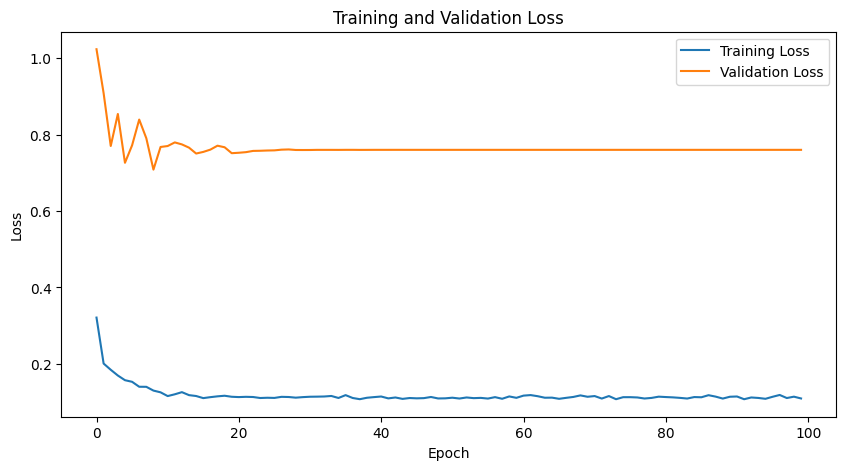

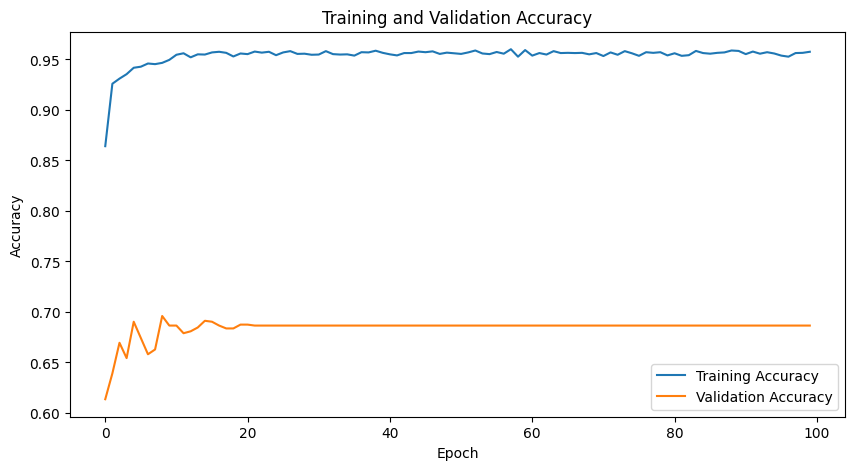

Epoch 1/100
----------


100%|██████████| 75/75 [00:16<00:00,  4.42it/s]

train Loss: 0.1252 Acc: 0.9513 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.13it/s]

val Loss: 0.8311 Acc: 0.6629 CD Loss: 0.0000
Epoch 2/100
----------



100%|██████████| 75/75 [00:15<00:00,  5.00it/s]

train Loss: 0.1175 Acc: 0.9544 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.02it/s]

val Loss: 0.7510 Acc: 0.6847 CD Loss: 0.0000
Epoch 3/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.86it/s]

train Loss: 0.1164 Acc: 0.9536 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.83it/s]

val Loss: 0.7464 Acc: 0.6894 CD Loss: 0.0000
Epoch 4/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.90it/s]

train Loss: 0.1159 Acc: 0.9536 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.98it/s]

val Loss: 0.7256 Acc: 0.6951 CD Loss: 0.0000
Epoch 5/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.89it/s]

train Loss: 0.1102 Acc: 0.9580 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.04it/s]


val Loss: 0.7771 Acc: 0.6809 CD Loss: 0.0000
Epoch 6/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.90it/s]

train Loss: 0.1040 Acc: 0.9584 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.04it/s]

val Loss: 0.7894 Acc: 0.6790 CD Loss: 0.0000
Epoch 7/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.73it/s]

train Loss: 0.0983 Acc: 0.9620 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.17it/s]

val Loss: 0.7177 Acc: 0.7064 CD Loss: 0.0000
Epoch 8/100
----------



100%|██████████| 75/75 [00:14<00:00,  5.08it/s]

train Loss: 0.0996 Acc: 0.9595 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.20it/s]

val Loss: 0.6776 Acc: 0.7197 CD Loss: 0.0000
Epoch 9/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.92it/s]

train Loss: 0.0945 Acc: 0.9641 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.96it/s]

val Loss: 0.8117 Acc: 0.6761 CD Loss: 0.0000
Epoch 10/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.97it/s]

train Loss: 0.0879 Acc: 0.9635 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.14it/s]


val Loss: 0.7065 Acc: 0.7206 CD Loss: 0.0000
Epoch 11/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.86it/s]

train Loss: 0.0810 Acc: 0.9684 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.00it/s]

val Loss: 0.7031 Acc: 0.7225 CD Loss: 0.0000
Epoch 12/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.83it/s]

train Loss: 0.0870 Acc: 0.9684 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.12it/s]

val Loss: 0.7206 Acc: 0.7131 CD Loss: 0.0000
Epoch 13/100
----------



100%|██████████| 75/75 [00:14<00:00,  5.02it/s]

train Loss: 0.0853 Acc: 0.9650 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.90it/s]

val Loss: 0.7213 Acc: 0.7121 CD Loss: 0.0000
Epoch 14/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.99it/s]

train Loss: 0.0848 Acc: 0.9669 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.11it/s]

val Loss: 0.7082 Acc: 0.7206 CD Loss: 0.0000
Epoch 15/100
----------



100%|██████████| 75/75 [00:14<00:00,  5.06it/s]

train Loss: 0.0844 Acc: 0.9681 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.90it/s]


val Loss: 0.7309 Acc: 0.7112 CD Loss: 0.0000
Epoch 16/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.92it/s]

train Loss: 0.0842 Acc: 0.9671 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.26it/s]

val Loss: 0.7154 Acc: 0.7206 CD Loss: 0.0000
Epoch 17/100
----------



100%|██████████| 75/75 [00:14<00:00,  5.02it/s]

train Loss: 0.0847 Acc: 0.9681 CD Loss: 0.0000



100%|██████████| 17/17 [00:04<00:00,  4.17it/s]

val Loss: 0.7137 Acc: 0.7206 CD Loss: 0.0000
Epoch 18/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.95it/s]

train Loss: 0.0772 Acc: 0.9675 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.17it/s]


val Loss: 0.7116 Acc: 0.7235 CD Loss: 0.0000
Epoch 19/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.99it/s]

train Loss: 0.0809 Acc: 0.9669 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.06it/s]

val Loss: 0.6997 Acc: 0.7254 CD Loss: 0.0000
Epoch 20/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.85it/s]

train Loss: 0.0808 Acc: 0.9662 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.11it/s]


val Loss: 0.7016 Acc: 0.7263 CD Loss: 0.0000
Epoch 21/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.90it/s]

train Loss: 0.0829 Acc: 0.9671 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.19it/s]

val Loss: 0.7023 Acc: 0.7254 CD Loss: 0.0000
Epoch 22/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.85it/s]

train Loss: 0.0843 Acc: 0.9662 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.13it/s]

val Loss: 0.7037 Acc: 0.7235 CD Loss: 0.0000
Epoch 23/100
----------



100%|██████████| 75/75 [00:14<00:00,  5.03it/s]

train Loss: 0.0827 Acc: 0.9694 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.06it/s]

val Loss: 0.7033 Acc: 0.7235 CD Loss: 0.0000
Epoch 24/100
----------



100%|██████████| 75/75 [00:15<00:00,  5.00it/s]

train Loss: 0.0803 Acc: 0.9656 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.94it/s]

val Loss: 0.7030 Acc: 0.7235 CD Loss: 0.0000
Epoch 25/100
----------



100%|██████████| 75/75 [00:14<00:00,  5.02it/s]

train Loss: 0.0835 Acc: 0.9673 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.18it/s]


val Loss: 0.7063 Acc: 0.7225 CD Loss: 0.0000
Epoch 26/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.95it/s]

train Loss: 0.0826 Acc: 0.9673 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.88it/s]

val Loss: 0.7092 Acc: 0.7225 CD Loss: 0.0000
Epoch 27/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.81it/s]

train Loss: 0.0793 Acc: 0.9696 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.93it/s]

val Loss: 0.7093 Acc: 0.7225 CD Loss: 0.0000
Epoch 28/100
----------



100%|██████████| 75/75 [00:13<00:00,  5.49it/s]

train Loss: 0.0820 Acc: 0.9675 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.08it/s]

val Loss: 0.7106 Acc: 0.7225 CD Loss: 0.0000
Epoch 29/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.97it/s]

train Loss: 0.0839 Acc: 0.9671 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.11it/s]

val Loss: 0.7118 Acc: 0.7216 CD Loss: 0.0000
Epoch 30/100
----------



100%|██████████| 75/75 [00:14<00:00,  5.05it/s]

train Loss: 0.0802 Acc: 0.9671 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.07it/s]


val Loss: 0.7100 Acc: 0.7225 CD Loss: 0.0000
Epoch 31/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.90it/s]

train Loss: 0.0826 Acc: 0.9665 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.07it/s]

val Loss: 0.7097 Acc: 0.7225 CD Loss: 0.0000
Epoch 32/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.84it/s]

train Loss: 0.0775 Acc: 0.9711 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.21it/s]

val Loss: 0.7096 Acc: 0.7225 CD Loss: 0.0000
Epoch 33/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.95it/s]

train Loss: 0.0822 Acc: 0.9673 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.84it/s]

val Loss: 0.7096 Acc: 0.7225 CD Loss: 0.0000
Epoch 34/100
----------



100%|██████████| 75/75 [00:15<00:00,  5.00it/s]

train Loss: 0.0823 Acc: 0.9665 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.97it/s]

val Loss: 0.7096 Acc: 0.7225 CD Loss: 0.0000
Epoch 35/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.96it/s]

train Loss: 0.0794 Acc: 0.9688 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.00it/s]


val Loss: 0.7097 Acc: 0.7225 CD Loss: 0.0000
Epoch 36/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.85it/s]

train Loss: 0.0826 Acc: 0.9677 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.89it/s]

val Loss: 0.7097 Acc: 0.7225 CD Loss: 0.0000
Epoch 37/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.76it/s]

train Loss: 0.0829 Acc: 0.9675 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.86it/s]

val Loss: 0.7100 Acc: 0.7225 CD Loss: 0.0000
Epoch 38/100
----------



100%|██████████| 75/75 [00:14<00:00,  5.05it/s]

train Loss: 0.0799 Acc: 0.9690 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.03it/s]

val Loss: 0.7101 Acc: 0.7225 CD Loss: 0.0000
Epoch 39/100
----------



100%|██████████| 75/75 [00:14<00:00,  5.03it/s]

train Loss: 0.0794 Acc: 0.9671 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.81it/s]

val Loss: 0.7100 Acc: 0.7225 CD Loss: 0.0000
Epoch 40/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.95it/s]

train Loss: 0.0824 Acc: 0.9669 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.11it/s]


val Loss: 0.7101 Acc: 0.7225 CD Loss: 0.0000
Epoch 41/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.89it/s]

train Loss: 0.0794 Acc: 0.9677 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.83it/s]


val Loss: 0.7101 Acc: 0.7225 CD Loss: 0.0000
Epoch 42/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.80it/s]

train Loss: 0.0781 Acc: 0.9690 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.24it/s]

val Loss: 0.7101 Acc: 0.7225 CD Loss: 0.0000
Epoch 43/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.90it/s]

train Loss: 0.0799 Acc: 0.9677 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.00it/s]


val Loss: 0.7101 Acc: 0.7225 CD Loss: 0.0000
Epoch 44/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.99it/s]

train Loss: 0.0842 Acc: 0.9648 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.05it/s]

val Loss: 0.7101 Acc: 0.7225 CD Loss: 0.0000
Epoch 45/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.97it/s]

train Loss: 0.0820 Acc: 0.9669 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.01it/s]


val Loss: 0.7101 Acc: 0.7225 CD Loss: 0.0000
Epoch 46/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.84it/s]

train Loss: 0.0821 Acc: 0.9679 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.18it/s]

val Loss: 0.7101 Acc: 0.7225 CD Loss: 0.0000
Epoch 47/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.86it/s]

train Loss: 0.0776 Acc: 0.9684 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.03it/s]

val Loss: 0.7101 Acc: 0.7225 CD Loss: 0.0000
Epoch 48/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.89it/s]

train Loss: 0.0773 Acc: 0.9684 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.00it/s]

val Loss: 0.7101 Acc: 0.7225 CD Loss: 0.0000
Epoch 49/100
----------



100%|██████████| 75/75 [00:15<00:00,  5.00it/s]

train Loss: 0.0837 Acc: 0.9673 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.10it/s]

val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 50/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.93it/s]

train Loss: 0.0815 Acc: 0.9690 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.83it/s]


val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 51/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.90it/s]

train Loss: 0.0761 Acc: 0.9694 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.15it/s]

val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 52/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.85it/s]

train Loss: 0.0797 Acc: 0.9662 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.79it/s]

val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 53/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.90it/s]

train Loss: 0.0791 Acc: 0.9707 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.16it/s]

val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 54/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.97it/s]

train Loss: 0.0823 Acc: 0.9671 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.85it/s]

val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 55/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.92it/s]

train Loss: 0.0820 Acc: 0.9667 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.24it/s]


val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 56/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.90it/s]

train Loss: 0.0811 Acc: 0.9705 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.77it/s]

val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 57/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.75it/s]

train Loss: 0.0782 Acc: 0.9684 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.15it/s]

val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 58/100
----------



100%|██████████| 75/75 [00:14<00:00,  5.04it/s]

train Loss: 0.0842 Acc: 0.9658 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.95it/s]

val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 59/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.95it/s]

train Loss: 0.0833 Acc: 0.9686 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.09it/s]


val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 60/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.95it/s]

train Loss: 0.0811 Acc: 0.9660 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.02it/s]


val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 61/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.79it/s]

train Loss: 0.0826 Acc: 0.9646 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.06it/s]

val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 62/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.81it/s]

train Loss: 0.0836 Acc: 0.9673 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.11it/s]

val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 63/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.94it/s]

train Loss: 0.0836 Acc: 0.9654 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.14it/s]

val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 64/100
----------



100%|██████████| 75/75 [00:14<00:00,  5.04it/s]

train Loss: 0.0806 Acc: 0.9679 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.12it/s]

val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 65/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.96it/s]

train Loss: 0.0800 Acc: 0.9675 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.96it/s]


val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 66/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.93it/s]

train Loss: 0.0796 Acc: 0.9711 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.28it/s]

val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 67/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.87it/s]

train Loss: 0.0803 Acc: 0.9694 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.95it/s]

val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 68/100
----------



100%|██████████| 75/75 [00:14<00:00,  5.02it/s]

train Loss: 0.0839 Acc: 0.9684 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.22it/s]

val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 69/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.91it/s]

train Loss: 0.0813 Acc: 0.9690 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.63it/s]

val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 70/100
----------



100%|██████████| 75/75 [00:14<00:00,  5.00it/s]

train Loss: 0.0776 Acc: 0.9694 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.15it/s]


val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 71/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.95it/s]

train Loss: 0.0812 Acc: 0.9694 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.91it/s]

val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 72/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.98it/s]

train Loss: 0.0792 Acc: 0.9696 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.42it/s]

val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 73/100
----------



100%|██████████| 75/75 [00:14<00:00,  5.01it/s]

train Loss: 0.0821 Acc: 0.9677 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.04it/s]

val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 74/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.99it/s]

train Loss: 0.0825 Acc: 0.9665 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.06it/s]

val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 75/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.96it/s]

train Loss: 0.0821 Acc: 0.9679 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.20it/s]


val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 76/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.88it/s]

train Loss: 0.0814 Acc: 0.9671 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.09it/s]

val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 77/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.84it/s]

train Loss: 0.0789 Acc: 0.9711 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.06it/s]

val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 78/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.95it/s]

train Loss: 0.0812 Acc: 0.9688 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.13it/s]

val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 79/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.96it/s]

train Loss: 0.0773 Acc: 0.9694 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.13it/s]

val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 80/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.93it/s]

train Loss: 0.0822 Acc: 0.9671 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.89it/s]


val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 81/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.91it/s]

train Loss: 0.0789 Acc: 0.9665 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.02it/s]

val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 82/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.85it/s]

train Loss: 0.0788 Acc: 0.9690 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.89it/s]

val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 83/100
----------



100%|██████████| 75/75 [00:14<00:00,  5.04it/s]

train Loss: 0.0837 Acc: 0.9669 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.14it/s]

val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 84/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.93it/s]

train Loss: 0.0797 Acc: 0.9686 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.74it/s]

val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 85/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.97it/s]

train Loss: 0.0802 Acc: 0.9681 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.05it/s]


val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 86/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.84it/s]

train Loss: 0.0817 Acc: 0.9660 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.93it/s]

val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 87/100
----------



100%|██████████| 75/75 [00:14<00:00,  5.03it/s]

train Loss: 0.0777 Acc: 0.9692 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.39it/s]

val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 88/100
----------



100%|██████████| 75/75 [00:14<00:00,  5.07it/s]

train Loss: 0.0800 Acc: 0.9696 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.07it/s]

val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 89/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.91it/s]

train Loss: 0.0784 Acc: 0.9692 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.22it/s]

val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 90/100
----------



100%|██████████| 75/75 [00:14<00:00,  5.05it/s]

train Loss: 0.0827 Acc: 0.9684 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.32it/s]


val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 91/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.88it/s]

train Loss: 0.0839 Acc: 0.9656 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.12it/s]

val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 92/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.77it/s]

train Loss: 0.0793 Acc: 0.9677 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.28it/s]

val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 93/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.91it/s]

train Loss: 0.0752 Acc: 0.9705 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.90it/s]

val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 94/100
----------



100%|██████████| 75/75 [00:15<00:00,  5.00it/s]

train Loss: 0.0820 Acc: 0.9669 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.08it/s]

val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 95/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.88it/s]

train Loss: 0.0858 Acc: 0.9673 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.78it/s]


val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 96/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.86it/s]

train Loss: 0.0802 Acc: 0.9690 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.15it/s]

val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 97/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.77it/s]

train Loss: 0.0809 Acc: 0.9675 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.88it/s]

val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 98/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.99it/s]

train Loss: 0.0805 Acc: 0.9700 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.21it/s]

val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 99/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.91it/s]

train Loss: 0.0836 Acc: 0.9650 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.84it/s]

val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Epoch 100/100
----------



100%|██████████| 75/75 [00:14<00:00,  5.00it/s]

train Loss: 0.0827 Acc: 0.9675 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.11it/s]


val Loss: 0.7102 Acc: 0.7225 CD Loss: 0.0000
Training complete in 31m 24s
Best val loss: 0.6776


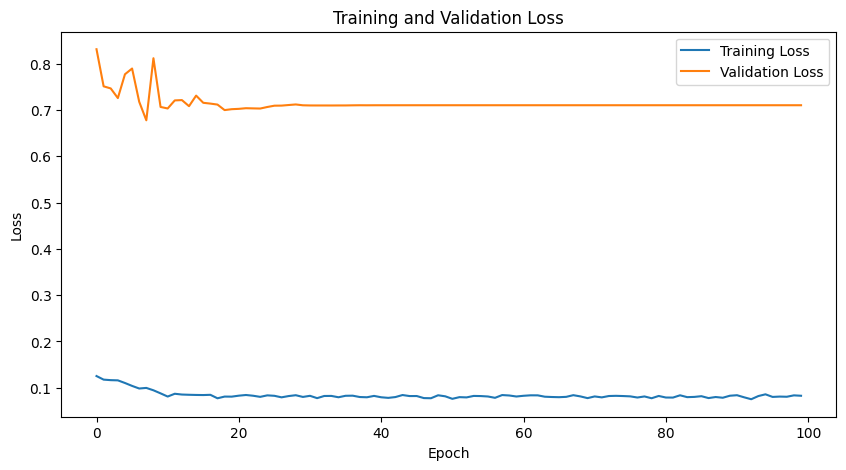

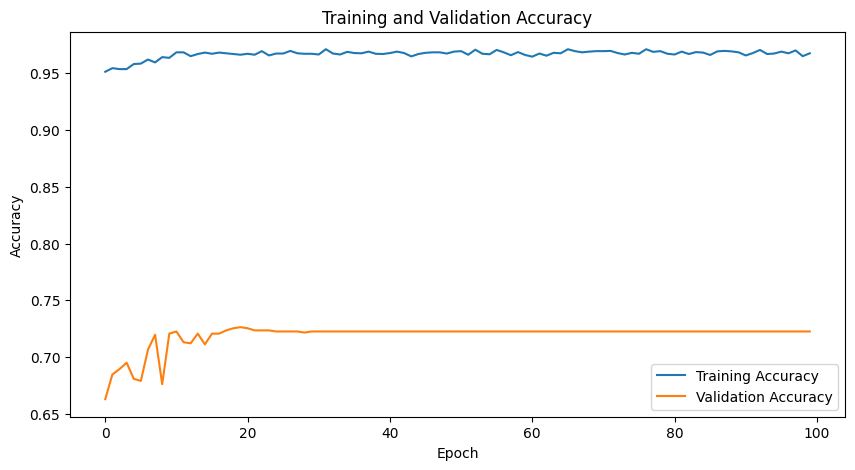

Epoch 1/100
----------


100%|██████████| 75/75 [00:16<00:00,  4.44it/s]

train Loss: 0.0957 Acc: 0.9643 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.95it/s]

val Loss: 0.8029 Acc: 0.6742 CD Loss: 0.0000
Epoch 2/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.84it/s]

train Loss: 0.0873 Acc: 0.9658 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.92it/s]

val Loss: 0.6942 Acc: 0.7244 CD Loss: 0.0000
Epoch 3/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.95it/s]

train Loss: 0.0890 Acc: 0.9652 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.84it/s]

val Loss: 0.6574 Acc: 0.7339 CD Loss: 0.0000
Epoch 4/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.95it/s]

train Loss: 0.0870 Acc: 0.9665 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.10it/s]

val Loss: 0.7720 Acc: 0.7008 CD Loss: 0.0000
Epoch 5/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.95it/s]

train Loss: 0.0824 Acc: 0.9671 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.87it/s]


val Loss: 0.7706 Acc: 0.7017 CD Loss: 0.0000
Epoch 6/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.87it/s]

train Loss: 0.0787 Acc: 0.9690 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.29it/s]

val Loss: 0.7584 Acc: 0.7083 CD Loss: 0.0000
Epoch 7/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.85it/s]

train Loss: 0.0735 Acc: 0.9692 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.86it/s]

val Loss: 0.6906 Acc: 0.7339 CD Loss: 0.0000
Epoch 8/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.94it/s]

train Loss: 0.0753 Acc: 0.9679 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.06it/s]

val Loss: 0.6861 Acc: 0.7348 CD Loss: 0.0000
Epoch 9/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.99it/s]

train Loss: 0.0715 Acc: 0.9698 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.09it/s]

val Loss: 0.6455 Acc: 0.7509 CD Loss: 0.0000
Epoch 10/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.94it/s]

train Loss: 0.0718 Acc: 0.9719 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.21it/s]


val Loss: 0.8555 Acc: 0.6941 CD Loss: 0.0000
Epoch 11/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.87it/s]

train Loss: 0.0688 Acc: 0.9703 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.02it/s]

val Loss: 0.7628 Acc: 0.7206 CD Loss: 0.0000
Epoch 12/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.92it/s]

train Loss: 0.0625 Acc: 0.9749 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.42it/s]

val Loss: 0.7152 Acc: 0.7339 CD Loss: 0.0000
Epoch 13/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.94it/s]

train Loss: 0.0678 Acc: 0.9730 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.02it/s]

val Loss: 0.7198 Acc: 0.7311 CD Loss: 0.0000
Epoch 14/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.98it/s]

train Loss: 0.0604 Acc: 0.9753 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.12it/s]

val Loss: 0.7151 Acc: 0.7320 CD Loss: 0.0000
Epoch 15/100
----------



100%|██████████| 75/75 [00:14<00:00,  5.08it/s]

train Loss: 0.0636 Acc: 0.9753 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.19it/s]


val Loss: 0.7178 Acc: 0.7311 CD Loss: 0.0000
Epoch 16/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.89it/s]

train Loss: 0.0622 Acc: 0.9745 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.98it/s]

val Loss: 0.7048 Acc: 0.7348 CD Loss: 0.0000
Epoch 17/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.79it/s]

train Loss: 0.0649 Acc: 0.9747 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.19it/s]

val Loss: 0.7082 Acc: 0.7339 CD Loss: 0.0000
Epoch 18/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.88it/s]

train Loss: 0.0609 Acc: 0.9747 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.77it/s]


val Loss: 0.6848 Acc: 0.7443 CD Loss: 0.0000
Epoch 19/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.91it/s]

train Loss: 0.0635 Acc: 0.9755 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.13it/s]

val Loss: 0.7024 Acc: 0.7377 CD Loss: 0.0000
Epoch 20/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.98it/s]

train Loss: 0.0620 Acc: 0.9770 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.81it/s]


val Loss: 0.7083 Acc: 0.7320 CD Loss: 0.0000
Epoch 21/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.93it/s]

train Loss: 0.0562 Acc: 0.9774 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.06it/s]

val Loss: 0.7056 Acc: 0.7348 CD Loss: 0.0000
Epoch 22/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.76it/s]

train Loss: 0.0594 Acc: 0.9774 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.93it/s]

val Loss: 0.7032 Acc: 0.7358 CD Loss: 0.0000
Epoch 23/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.98it/s]

train Loss: 0.0622 Acc: 0.9753 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.96it/s]

val Loss: 0.7060 Acc: 0.7348 CD Loss: 0.0000
Epoch 24/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.98it/s]

train Loss: 0.0649 Acc: 0.9751 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.84it/s]

val Loss: 0.7044 Acc: 0.7358 CD Loss: 0.0000
Epoch 25/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.98it/s]

train Loss: 0.0622 Acc: 0.9743 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.22it/s]


val Loss: 0.7015 Acc: 0.7358 CD Loss: 0.0000
Epoch 26/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.90it/s]

train Loss: 0.0615 Acc: 0.9770 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.05it/s]

val Loss: 0.7008 Acc: 0.7358 CD Loss: 0.0000
Epoch 27/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.95it/s]

train Loss: 0.0630 Acc: 0.9745 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.60it/s]

val Loss: 0.7007 Acc: 0.7367 CD Loss: 0.0000
Epoch 28/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.98it/s]

train Loss: 0.0627 Acc: 0.9751 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.07it/s]

val Loss: 0.7011 Acc: 0.7367 CD Loss: 0.0000
Epoch 29/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.96it/s]

train Loss: 0.0611 Acc: 0.9768 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.01it/s]

val Loss: 0.7013 Acc: 0.7367 CD Loss: 0.0000
Epoch 30/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.91it/s]

train Loss: 0.0579 Acc: 0.9759 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.20it/s]


val Loss: 0.7013 Acc: 0.7377 CD Loss: 0.0000
Epoch 31/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.86it/s]

train Loss: 0.0638 Acc: 0.9757 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.19it/s]

val Loss: 0.7013 Acc: 0.7377 CD Loss: 0.0000
Epoch 32/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.86it/s]

train Loss: 0.0649 Acc: 0.9730 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.07it/s]

val Loss: 0.7013 Acc: 0.7367 CD Loss: 0.0000
Epoch 33/100
----------



100%|██████████| 75/75 [00:14<00:00,  5.00it/s]

train Loss: 0.0628 Acc: 0.9738 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.97it/s]

val Loss: 0.7013 Acc: 0.7377 CD Loss: 0.0000
Epoch 34/100
----------



100%|██████████| 75/75 [00:14<00:00,  5.02it/s]

train Loss: 0.0617 Acc: 0.9751 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.04it/s]

val Loss: 0.7011 Acc: 0.7377 CD Loss: 0.0000
Epoch 35/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.84it/s]

train Loss: 0.0632 Acc: 0.9745 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.80it/s]


val Loss: 0.7009 Acc: 0.7377 CD Loss: 0.0000
Epoch 36/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.91it/s]

train Loss: 0.0615 Acc: 0.9770 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.17it/s]

val Loss: 0.7010 Acc: 0.7377 CD Loss: 0.0000
Epoch 37/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.85it/s]

train Loss: 0.0654 Acc: 0.9722 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.93it/s]

val Loss: 0.7010 Acc: 0.7377 CD Loss: 0.0000
Epoch 38/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.91it/s]

train Loss: 0.0619 Acc: 0.9736 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.04it/s]

val Loss: 0.7009 Acc: 0.7377 CD Loss: 0.0000
Epoch 39/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.98it/s]

train Loss: 0.0581 Acc: 0.9774 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.94it/s]

val Loss: 0.7005 Acc: 0.7377 CD Loss: 0.0000
Epoch 40/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.94it/s]

train Loss: 0.0615 Acc: 0.9753 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.29it/s]


val Loss: 0.7004 Acc: 0.7377 CD Loss: 0.0000
Epoch 41/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.93it/s]

train Loss: 0.0590 Acc: 0.9762 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.93it/s]

val Loss: 0.7004 Acc: 0.7377 CD Loss: 0.0000
Epoch 42/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.77it/s]

train Loss: 0.0617 Acc: 0.9743 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.96it/s]

val Loss: 0.7004 Acc: 0.7377 CD Loss: 0.0000
Epoch 43/100
----------



100%|██████████| 75/75 [00:15<00:00,  5.00it/s]

train Loss: 0.0588 Acc: 0.9757 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.90it/s]

val Loss: 0.7004 Acc: 0.7377 CD Loss: 0.0000
Epoch 44/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.90it/s]

train Loss: 0.0587 Acc: 0.9783 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.07it/s]

val Loss: 0.7004 Acc: 0.7377 CD Loss: 0.0000
Epoch 45/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.96it/s]

train Loss: 0.0621 Acc: 0.9774 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.01it/s]


val Loss: 0.7004 Acc: 0.7377 CD Loss: 0.0000
Epoch 46/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.83it/s]

train Loss: 0.0606 Acc: 0.9751 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.95it/s]

val Loss: 0.7004 Acc: 0.7377 CD Loss: 0.0000
Epoch 47/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.77it/s]

train Loss: 0.0597 Acc: 0.9753 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.09it/s]

val Loss: 0.7004 Acc: 0.7377 CD Loss: 0.0000
Epoch 48/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.97it/s]

train Loss: 0.0644 Acc: 0.9726 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.09it/s]

val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 49/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.96it/s]

train Loss: 0.0537 Acc: 0.9802 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.28it/s]

val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 50/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.98it/s]

train Loss: 0.0604 Acc: 0.9759 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.03it/s]


val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 51/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.85it/s]

train Loss: 0.0614 Acc: 0.9766 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.05it/s]

val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 52/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.78it/s]

train Loss: 0.0661 Acc: 0.9743 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.89it/s]


val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 53/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.98it/s]

train Loss: 0.0618 Acc: 0.9770 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.10it/s]

val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 54/100
----------



100%|██████████| 75/75 [00:14<00:00,  5.06it/s]

train Loss: 0.0586 Acc: 0.9753 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.83it/s]

val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 55/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.99it/s]

train Loss: 0.0627 Acc: 0.9741 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.05it/s]


val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 56/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.91it/s]

train Loss: 0.0584 Acc: 0.9789 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.87it/s]

val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 57/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.85it/s]

train Loss: 0.0590 Acc: 0.9749 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.14it/s]

val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 58/100
----------



100%|██████████| 75/75 [00:14<00:00,  5.04it/s]

train Loss: 0.0659 Acc: 0.9732 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.01it/s]

val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 59/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.93it/s]

train Loss: 0.0619 Acc: 0.9749 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.15it/s]

val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 60/100
----------



100%|██████████| 75/75 [00:14<00:00,  5.02it/s]

train Loss: 0.0618 Acc: 0.9766 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.00it/s]


val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 61/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.85it/s]

train Loss: 0.0609 Acc: 0.9770 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.08it/s]

val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 62/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.81it/s]

train Loss: 0.0623 Acc: 0.9755 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.05it/s]


val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 63/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.90it/s]

train Loss: 0.0605 Acc: 0.9762 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.12it/s]

val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 64/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.92it/s]

train Loss: 0.0568 Acc: 0.9770 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.93it/s]

val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 65/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.96it/s]

train Loss: 0.0616 Acc: 0.9772 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.01it/s]


val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 66/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.90it/s]

train Loss: 0.0629 Acc: 0.9741 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.27it/s]

val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 67/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.81it/s]

train Loss: 0.0583 Acc: 0.9764 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.92it/s]

val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 68/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.80it/s]

train Loss: 0.0645 Acc: 0.9751 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.02it/s]

val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 69/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.96it/s]

train Loss: 0.0637 Acc: 0.9764 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.83it/s]

val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 70/100
----------



100%|██████████| 75/75 [00:14<00:00,  5.02it/s]

train Loss: 0.0623 Acc: 0.9764 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.21it/s]


val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 71/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.97it/s]

train Loss: 0.0599 Acc: 0.9764 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.87it/s]

val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 72/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.80it/s]

train Loss: 0.0608 Acc: 0.9749 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.07it/s]

val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 73/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.94it/s]

train Loss: 0.0615 Acc: 0.9766 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.87it/s]

val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 74/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.99it/s]

train Loss: 0.0652 Acc: 0.9722 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.05it/s]

val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 75/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.96it/s]

train Loss: 0.0604 Acc: 0.9757 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.18it/s]


val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 76/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.84it/s]

train Loss: 0.0629 Acc: 0.9736 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.92it/s]

val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 77/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.79it/s]

train Loss: 0.0599 Acc: 0.9749 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.95it/s]

val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 78/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.96it/s]

train Loss: 0.0620 Acc: 0.9743 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.99it/s]

val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 79/100
----------



100%|██████████| 75/75 [00:14<00:00,  5.02it/s]

train Loss: 0.0583 Acc: 0.9776 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.19it/s]

val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 80/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.98it/s]

train Loss: 0.0657 Acc: 0.9732 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.10it/s]


val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 81/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.94it/s]

train Loss: 0.0595 Acc: 0.9747 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.91it/s]

val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 82/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.77it/s]

train Loss: 0.0617 Acc: 0.9738 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.16it/s]

val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 83/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.95it/s]

train Loss: 0.0605 Acc: 0.9766 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.04it/s]

val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 84/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.96it/s]

train Loss: 0.0629 Acc: 0.9755 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.77it/s]

val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 85/100
----------



100%|██████████| 75/75 [00:14<00:00,  5.02it/s]

train Loss: 0.0629 Acc: 0.9762 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.12it/s]


val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 86/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.86it/s]

train Loss: 0.0620 Acc: 0.9755 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.74it/s]


val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 87/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.75it/s]

train Loss: 0.0622 Acc: 0.9759 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.02it/s]

val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 88/100
----------



100%|██████████| 75/75 [00:14<00:00,  5.02it/s]

train Loss: 0.0593 Acc: 0.9787 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.79it/s]

val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 89/100
----------



100%|██████████| 75/75 [00:15<00:00,  5.00it/s]

train Loss: 0.0637 Acc: 0.9734 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.21it/s]

val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 90/100
----------



100%|██████████| 75/75 [00:14<00:00,  5.03it/s]

train Loss: 0.0655 Acc: 0.9736 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.90it/s]


val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 91/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.87it/s]

train Loss: 0.0640 Acc: 0.9745 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.11it/s]

val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 92/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.79it/s]

train Loss: 0.0609 Acc: 0.9749 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  4.89it/s]

val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 93/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.96it/s]

train Loss: 0.0597 Acc: 0.9774 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.05it/s]

val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 94/100
----------



100%|██████████| 75/75 [00:14<00:00,  5.02it/s]

train Loss: 0.0643 Acc: 0.9741 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.05it/s]


val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 95/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.93it/s]

train Loss: 0.0591 Acc: 0.9757 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.13it/s]


val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 96/100
----------


100%|██████████| 75/75 [00:15<00:00,  4.90it/s]

train Loss: 0.0622 Acc: 0.9774 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.20it/s]

val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 97/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.78it/s]

train Loss: 0.0649 Acc: 0.9738 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.13it/s]

val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 98/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.97it/s]

train Loss: 0.0651 Acc: 0.9745 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.07it/s]

val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 99/100
----------



100%|██████████| 75/75 [00:15<00:00,  4.93it/s]

train Loss: 0.0601 Acc: 0.9757 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.03it/s]

val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Epoch 100/100
----------



100%|██████████| 75/75 [00:14<00:00,  5.04it/s]

train Loss: 0.0615 Acc: 0.9749 CD Loss: 0.0000



100%|██████████| 17/17 [00:03<00:00,  5.10it/s]


val Loss: 0.7003 Acc: 0.7377 CD Loss: 0.0000
Training complete in 31m 28s
Best val loss: 0.6455


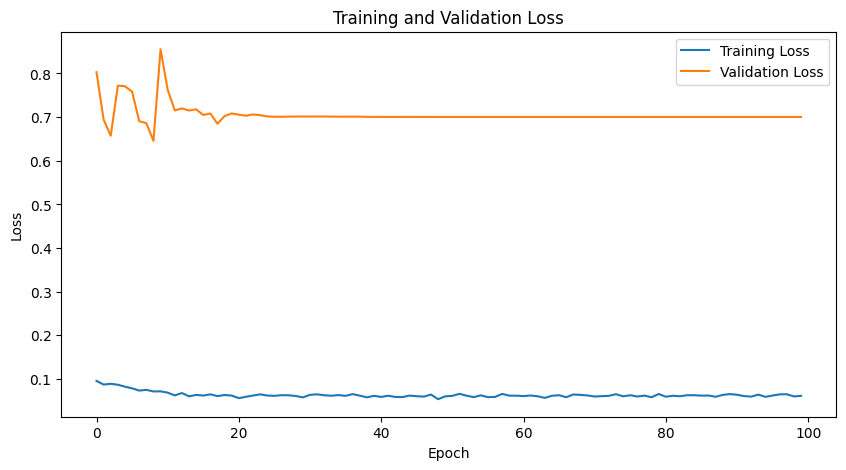

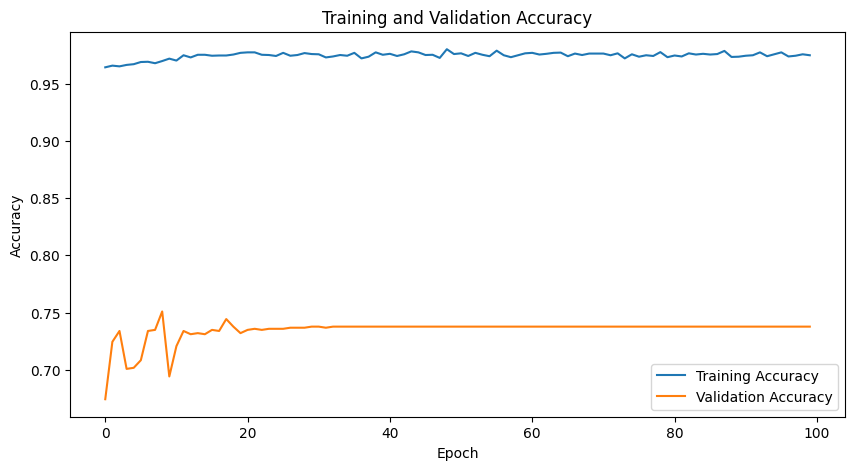

"\nargs = Args()\n\nregularizer_rate = args.regularizer_rate\nnum_epochs = args.epochs\n\ntorch.manual_seed(args.seed)\ndevice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')\nmodel.to(device)\n#params_to_update = model.classifier.parameters()\nparams_to_update = model.parameters()\n\noptimizer_ft = optim.SGD(params_to_update, lr=args.lr, momentum=args.momentum)\n"

In [11]:
wb_ratio = len(dataset_wb_nopatch_train)/len(train_dataset)

not_wb_ratio = 1 - wb_ratio
wb_weight = 1/wb_ratio
not_wb_weight = 1/ not_wb_ratio
weights = np.asarray([not_wb_weight, wb_weight])
weights /= weights.sum()
weights = torch.tensor(weights).to(device)

criterion = nn.CrossEntropyLoss(weight = weights.double().float())

mean = np.asarray([0.485, 0.456, 0.406])
std = np.asarray([0.229, 0.224, 0.225])


# Define arguments
class Args:
    def __init__(self, seed):
        self.batch_size = 64
        self.epochs = 100
        self.lr = 0.0001
        self.momentum = 0.9
        self.seed = seed
        self.regularizer_rate = 0.0

seeds = [1, 11, 111]



for seed in seeds:
    args = Args(seed)
    torch.manual_seed(args.seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    regularizer_rate = args.regularizer_rate
    num_epochs = args.epochs
    params_to_update = model.parameters()
    optimizer_ft = optim.SGD(params_to_update, lr=args.lr, momentum=args.momentum)

    model = train_model(model, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs, resume_training=False)
    torch.save(model.state_dict(), os.path.join(dir_path, model_path, f"alexnet_wbw_lbl_lbw_3_{seed}" + "train.pt"))






'''
args = Args()

regularizer_rate = args.regularizer_rate
num_epochs = args.epochs

torch.manual_seed(args.seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
#params_to_update = model.classifier.parameters()
params_to_update = model.parameters()

optimizer_ft = optim.SGD(params_to_update, lr=args.lr, momentum=args.momentum)
'''

In [16]:
import torch
import os
from torch.utils.data import DataLoader
import torch.nn as nn
from datetime import datetime

def load_model(model_path, device):
    print(f"Loading model from {model_path}")
    model = models.alexnet(pretrained=False)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.classifier[-1] = nn.Linear(4096, 2)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    print("Model loaded successfully")

    # Freeze all layers
    #for param in model.parameters():
        #param.requires_grad = False

    #print("Model loaded and layers frozen successfully")
    return model

# Function to test the model on a specific dataset
def test_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels, _ in dataloader:  # Ignore group_label
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total * 100
    return accuracy




test_wb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_nopatch'
test_wb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_patch'


# Create test datasets
dataset_test_wb_patch = WaterbirdDataset(path=test_wb_patch_path, is_waterbird=1, group_labels=[1] * len(os.listdir(test_wb_patch_path)))
dataset_test_wb_nopatch = WaterbirdDataset(path=test_wb_nopatch_path, is_waterbird=1, group_labels=[0] * len(os.listdir(test_wb_nopatch_path)))

# Create dataloaders for the test datasets
batch_size = 64
test_loader_wbp = DataLoader(dataset_test_wb_patch, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader_wbnp = DataLoader(dataset_test_wb_nopatch, batch_size=batch_size, shuffle=False, num_workers=2)

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load and test the model for each seed
seeds = [1, 11, 111]
for seed in seeds:
    model_path = f"/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/models/initial_classifier/alexnet_wbw_lbl_lbw_{seed}train.pt"

    print(f"\nLoading model with seed {seed}")
    model = load_model(model_path, device)

    # Test on wb oatch dataset
    accuracy_dlp = test_model(model, test_loader_wbp, device)
    print(f"Accuracy on waterbirds with patch test dataset (class_2): {accuracy_dlp:.2f}%")

    # Test on original dataset
    accuracy_org = test_model(model, test_loader_wbnp, device)
    print(f"Accuracy on waterbirds without patch test dataset (class_2): {accuracy_org:.2f}%")



Loading model with seed 1
Loading model from /content/drive/MyDrive/Masterthesis/Datasets/Waterbird/models/initial_classifier/alexnet_wbw_lbl_lbw_1train.pt


<ipython-input-16-e6de0001ad21>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Model loaded successfully
Accuracy on waterbirds with patch test dataset (class_2): 14.33%
Accuracy on waterbirds without patch test dataset (class_2): 93.15%

Loading model with seed 11
Loading model from /content/drive/MyDrive/Masterthesis/Datasets/Waterbird/models/initial_classifier/alexnet_wbw_lbl_lbw_11train.pt
Model loaded successfully
Accuracy on waterbirds with patch test dataset (class_2): 14.17%
Accuracy on waterbirds without patch test dataset (class_2): 92.06%

Loading model with seed 111
Loading model from /content/drive/MyDrive/Masterthesis/Datasets/Waterbird/models/initial_classifier/alexnet_wbw_lbl_lbw_111train.pt
Model loaded successfully
Accuracy on waterbirds with patch test dataset (class_2): 18.07%
Accuracy on waterbirds without patch test dataset (class_2): 92.37%


In [ ]:
stophere

Selective train (wbw, lbl)

In [ ]:
wb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/balanced_data/wb_no_patch'
lb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/balanced_data/lb_no_patch'
lb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/balanced_data/lb_patch'
wb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/balanced_data/wb_patch'




# Create datasets for training and testing
dataset_wb_nopatch = WaterbirdDataset(path=wb_nopatch_path, is_waterbird=1, group_labels=[3] * len(os.listdir(wb_nopatch_path)))
dataset_lb_nopatch = WaterbirdDataset(path=lb_nopatch_path, is_waterbird=0, group_labels=[0] * len(os.listdir(lb_nopatch_path)))
dataset_lb_patch = WaterbirdDataset(path=lb_patch_path, is_waterbird=0, group_labels=[1] * len(os.listdir(lb_patch_path)))
dataset_wb_patch = WaterbirdDataset(path=wb_patch_path, is_waterbird=0, group_labels=[1] * len(os.listdir(wb_patch_path)))


complete_dataset = ConcatDataset((dataset_wb_nopatch, dataset_lb_nopatch))
train_dataset = complete_dataset
test_dataset = dataset_wb_patch

batch_size = args.batch_size  # Assuming args.batch_size is defined

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
dataloaders = {'train': train_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'test': len(test_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_test:", dataset_sizes['test'])

# Example usage:
group_frequencies = {
    0: 3518,  # landbird_generic-spurious:birdonland
    1: 185,   # landbird_generic-spurious:birdonwater
    2: 55,    # waterbird_generic-spurious:birdonland
    3: 1037   # waterbird_generic-spurious:birdonwater
}



In [ ]:
wb_ratio = len(dataset_wb_nopatch)/len(complete_dataset)

not_wb_ratio = 1 - wb_ratio
wb_weight = 1/wb_ratio
not_wb_weight = 1/ not_wb_ratio
weights = np.asarray([not_wb_weight, wb_weight])
weights /= weights.sum()
weights = torch.tensor(weights).to(device)

criterion = nn.CrossEntropyLoss(weight = weights.double().float())

mean = np.asarray([0.485, 0.456, 0.406])
std = np.asarray([0.229, 0.224, 0.225])


# Define arguments
class Args:
    def __init__(self):
        self.batch_size = 64
        self.epochs = 100
        self.lr = 0.0001
        self.momentum = 0.9
        self.seed = 1
        self.regularizer_rate = 0.0

args = Args()

regularizer_rate = args.regularizer_rate
num_epochs = args.epochs

torch.manual_seed(args.seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
#params_to_update = model.classifier.parameters()
params_to_update = model.parameters()

optimizer_ft = optim.SGD(params_to_update, lr=args.lr, momentum=args.momentum)

In [ ]:
model = train_model(model, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs, resume_training=False)
pid = datetime.now().strftime('%Y%m%d%H%M%S')
torch.save(model.state_dict(), os.path.join(dir_path, model_path, pid + "alexnet_wbw_lbl_1_" +"train.pt"))

Full train

In [ ]:
wb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/balanced_data/wb_no_patch'
lb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/balanced_data/lb_no_patch'
lb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/balanced_data/lb_patch'
wb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/balanced_data/wb_patch'




# Create datasets for training and testing
dataset_wb_nopatch = WaterbirdDataset(path=wb_nopatch_path, is_waterbird=1, group_labels=[3] * len(os.listdir(wb_nopatch_path)))
dataset_lb_nopatch = WaterbirdDataset(path=lb_nopatch_path, is_waterbird=0, group_labels=[0] * len(os.listdir(lb_nopatch_path)))
dataset_lb_patch = WaterbirdDataset(path=lb_patch_path, is_waterbird=0, group_labels=[1] * len(os.listdir(lb_patch_path)))
dataset_wb_patch = WaterbirdDataset(path=wb_patch_path, is_waterbird=0, group_labels=[1] * len(os.listdir(wb_patch_path)))


complete_dataset = ConcatDataset((dataset_wb_nopatch, dataset_lb_nopatch, dataset_lb_patch, dataset_wb_patch))
dataset_wb = ConcatDataset((dataset_wb_nopatch, dataset_wb_patch))
train_dataset = complete_dataset
test_dataset = dataset_wb_patch

batch_size = args.batch_size  # Assuming args.batch_size is defined

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
dataloaders = {'train': train_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'test': len(test_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_test:", dataset_sizes['test'])

# Example usage:
group_frequencies = {
    0: 840,  # landbird_generic-spurious:birdonland
    1: 840,   # landbird_generic-spurious:birdonwater
    2: 840,    # waterbird_generic-spurious:birdonland
    3: 840   # waterbird_generic-spurious:birdonwater
}



In [ ]:
wb_ratio = len(dataset_wb)/len(complete_dataset)

not_wb_ratio = 1 - wb_ratio
wb_weight = 1/wb_ratio
not_wb_weight = 1/ not_wb_ratio
weights = np.asarray([not_wb_weight, wb_weight])
weights /= weights.sum()
weights = torch.tensor(weights).to(device)

criterion = nn.CrossEntropyLoss(weight = weights.double().float())


# Define arguments
class Args:
    def __init__(self):
        self.batch_size = 16
        self.epochs = 100
        self.lr = 0.00001
        self.momentum = 0.9
        self.seed = 42
        self.regularizer_rate = 0.0

args = Args()

regularizer_rate = args.regularizer_rate
num_epochs = args.epochs

torch.manual_seed(args.seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
#params_to_update = model.classifier.parameters()
params_to_update = model.parameters()

optimizer_ft = optim.SGD(params_to_update, lr=args.lr, momentum=args.momentum)

In [ ]:
model = train_model(model, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs, resume_training=False)
pid = datetime.now().strftime('%Y%m%d%H%M%S')
torch.save(model.state_dict(), os.path.join(dir_path, model_path, pid + "full_train_full_model.pt"))

## Functions for Evaluation

### Evaluation Metrics

In [ ]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, brier_score_loss, log_loss, precision_score, recall_score
import matplotlib.pyplot as plt

def get_output(model, dataset, device, batch_size=64):
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    model.eval()
    y_list = []
    y_hat_list = []
    group_labels_list = []
    softmax = torch.nn.Softmax(dim=1)

    with torch.no_grad():
        for data in data_loader:
            inputs, labels, group_labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            y_list.append(labels.cpu().numpy())
            y_hat_list.append(softmax(outputs).cpu().numpy()[:, 1])  # Extract probabilities for the positive class
            group_labels_list.append(group_labels.cpu().numpy())

    if not y_list or not y_hat_list or not group_labels_list:
        print("Warning: One or more lists are empty.")
        return None

    y = np.concatenate(y_list)
    y_hat = np.concatenate(y_hat_list)
    group_labels = np.concatenate(group_labels_list)

    # Convert probabilities to binary predictions
    preds = (y_hat >= 0.5).astype(int)

    # Calculate TP, TN, FP, FN
    tp = ((preds == 1) & (y == 1)).sum()
    tn = ((preds == 0) & (y == 0)).sum()
    fp = ((preds == 1) & (y == 0)).sum()
    fn = ((preds == 0) & (y == 1)).sum()

    # Print intermediate results for debugging
    print(f'TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}')
    print(f'y: {np.bincount(y)}, preds: {np.bincount(preds)}')  # Check distribution of labels and predictions

    return y, y_hat, group_labels, tp, tn, fp, fn

def get_auc_f1_acc_adj(model, dataset, group_frequencies, fname=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    if fname is not None:
        with open(fname, 'rb') as f:
            weights = torch.load(f)
        if "classifier.0.weight" in weights.keys():
            model.load_state_dict(weights)
        else:
            model.load_state_dict(weights)
        output = get_output(model, dataset, device)
    else:
        output = get_output(model, dataset, device)

    if output is None:
        print("Error: get_output returned None.")
        return None

    y, y_hat, group_labels, tp, tn, fp, fn = output

    unique_classes = np.unique(group_labels)
    if len(unique_classes) < 2:
        print("Warning: Test dataset has only one class. Metrics like ROC AUC and F1 Score cannot be computed.")
        acc = accuracy_score(y, (y_hat >= 0.5).astype(int))
        brier = brier_score_loss(y, y_hat)
        tpr = tp / (tp + fn) if (tp + fn) > 0 else None
        recall = tpr

        normal_metrics = (None, None, acc, tp, tn, fp, fn, brier, tpr)

        return {
            "normal": normal_metrics
        }

    threshold = 0.5
    y_pred = (y_hat >= threshold).astype(int)
    auc_score = roc_auc_score(y, y_hat)
    f1 = f1_score(y, y_pred)
    acc = accuracy_score(y, y_pred)
    brier = brier_score_loss(y, y_pred)
    nll = log_loss(y, y_pred)
    tpr = tp / (tp + fn) if (tp + fn) > 0 else None
    precision = tp / (tp + fp) if (tp + fp) > 0 else None
    recall = recall_score(y, y_pred)

    normal_metrics = (auc_score, f1, acc, tp, tn, fp, fn, brier, tpr)

    return {
        "normal": normal_metrics
    }


## Experiment 1:



   

### Baseline Performance Test:
Use the full training dataset: wb_patch, wb_no_patvh, lb_patch and lb_no_patch. For the first test we use wb_no_patch and for the second we use wb_patch.

with patch:

In [ ]:
train_wb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_wb_nopatch'
train_lb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_lb_nopatch'
train_lb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_lb_patch'
train_wb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_wb_patch'


test_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_patch'
test_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_nopatch'


# Create datasets for training and testing
train_dataset_wb_nopatch = WaterbirdDataset(path=train_wb_nopatch_path, is_waterbird=1, group_labels=[3] * len(os.listdir(train_wb_nopatch_path)))
train_dataset_lb_nopatch = WaterbirdDataset(path=train_lb_nopatch_path, is_waterbird=0, group_labels=[0] * len(os.listdir(train_lb_nopatch_path)))
train_dataset_lb_patch = WaterbirdDataset(path=train_lb_patch_path, is_waterbird=0, group_labels=[1] * len(os.listdir(train_lb_patch_path)))
train_dataset_wb_patch = WaterbirdDataset(path=train_wb_patch_path, is_waterbird=1, group_labels=[2] * len(os.listdir(train_wb_patch_path)))

test_patch_dataset = WaterbirdDataset(path=test_patch_path, is_waterbird=1, group_labels=[2] * len(os.listdir(test_patch_path)))
test_nopatch_dataset = WaterbirdDataset(path=test_nopatch_path, is_waterbird=1, group_labels=[3] * len(os.listdir(test_nopatch_path)))


train_dataset = ConcatDataset((train_dataset_wb_nopatch, train_dataset_lb_nopatch, train_dataset_lb_patch, train_dataset_wb_patch))


# Example usage:
group_frequencies = {
    0: 3518,  # landbird_generic-spurious:birdonland
    1: 185,   # landbird_generic-spurious:birdonwater
    2: 55,    # waterbird_generic-spurious:birdonland
    3: 1037   # waterbird_generic-spurious:birdonwater
}


#print('test dataset', test_dataset)

# Create dataloaders for training and testing datasets
batch_size = args.batch_size  # Assuming args.batch_size is defined

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_patch_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Organize dataloaders and dataset sizes in dictionaries
dataloaders = {'train': train_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'test': len(test_patch_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_test:", dataset_sizes['test'])

concat train_wb_patch and train_wb_no_patch and pass them in the first len(train_dataset)

In [ ]:
train_wb_dataset = ConcatDataset((train_dataset_wb_nopatch, train_dataset_wb_patch))
waterbird_ratio = len(train_wb_dataset) / (len(train_dataset))

not_waterbird_ratio = 1 - waterbird_ratio
waterbird_weight = 1/waterbird_ratio
not_waterbird_weight = 1/ not_waterbird_ratio
weights = np.asarray([not_waterbird_weight, waterbird_weight])
weights /= weights.sum()
weights = torch.tensor(weights).to(device)

criterion = nn.CrossEntropyLoss(weight = weights.double().float())


# Define arguments
class Args:
    def __init__(self):
        self.batch_size = 16
        self.epochs = 100
        self.lr = 0.00001
        self.momentum = 0.9
        self.seed = 42
        self.regularizer_rate = 0.0

args = Args()

regularizer_rate = args.regularizer_rate
num_epochs = args.epochs

torch.manual_seed(args.seed)

params_to_update = model.parameters()

optimizer_ft = optim.SGD(params_to_update, lr=args.lr, momentum=args.momentum)

In [ ]:
# Initialize AlexNet with modified classifier
#um_classes = 2
model = models.alexnet(weights=None)

model.classifier[-1] = nn.Linear(4096, 2)

# path to saved model state dictionary
saved_model_path = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/models/initial_classifier/20240710132545full_train_full_model.pt"

# Load the saved model state dictionary
state_dict = torch.load(saved_model_path)

# Load only the classifier part from state_dict
model.load_state_dict(state_dict)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Ensure model is in evaluation mode
#model.eval()

In [ ]:
# Assuming model, test_dataset, and group_frequencies are already defined
results = get_auc_f1_acc_adj(model, test_patch_dataset, group_frequencies)

if results and results["normal"] is not None:
    # Retrieve results for normal evaluation
    normal_metrics = results["normal"]
    auc, f1, acc, tp, tn, fp, fn, brier, tpr = normal_metrics

    print(f"Normal Evaluation - AUC: {auc}, F1: {f1}, Accuracy: {acc}, Brier Score: {brier}, TPR: {tpr}")
    print(f"True Positives: {tp}, True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}")
else:
    print("Normal Evaluation metrics cannot be computed due to a single class in the test dataset or another error.")

without patch:

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_nopatch_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Organize dataloaders and dataset sizes in dictionaries
dataloaders = {'train': train_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'test': len(test_nopatch_dataset)}

print("num_train:", dataset_sizes['train'])
print("num_test:", dataset_sizes['test'])

In [ ]:
# Assuming model, test_dataset, and group_frequencies are already defined
results = get_auc_f1_acc_adj(model, test_nopatch_dataset, group_frequencies)

if results and results["normal"] is not None:
    # Retrieve results for normal evaluation
    normal_metrics = results["normal"]
    auc, f1, acc, tp, tn, fp, fn, brier, tpr = normal_metrics

    print(f"Normal Evaluation - AUC: {auc}, F1: {f1}, Accuracy: {acc}, Brier Score: {brier}, TPR: {tpr}")
    print(f"True Positives: {tp}, True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}")
else:
    print("Normal Evaluation metrics cannot be computed due to a single class in the test dataset or another error.")



---



### Main Experiment

Introducing a new test set with spurious features that were not present in the trainig set

**Hypothesis**: Accuracy, Adj_Acc, TPs and Brier Score drop when testing with wb_patch after wb_no_patch.

**Design**:

*   Training set: on wb_no patch, lb_patch and lb_no patch.
*   Testing sets: first run on *wb_no_patch* and second run on *wb_patch*

**Evaluation Metrics:** Accuracy, Adj_Acc, TPs, FNs and Brier Score

**Results:**

no patch

In [ ]:
train_wb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_wb_nopatch'
train_lb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_lb_nopatch'
train_lb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_lb_patch'

test_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_patch'
test_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_nopatch'


# Create datasets for training and testing
train_dataset_wb_nopatch = WaterbirdDataset(path=train_wb_nopatch_path, is_waterbird=1, group_labels=[3] * len(os.listdir(train_wb_nopatch_path)))
train_dataset_lb_nopatch = WaterbirdDataset(path=train_lb_nopatch_path, is_waterbird=0, group_labels=[0] * len(os.listdir(train_lb_nopatch_path)))
train_dataset_lb_patch = WaterbirdDataset(path=train_lb_patch_path, is_waterbird=0, group_labels=[1] * len(os.listdir(train_lb_patch_path)))

test_patch_dataset = WaterbirdDataset(path=test_patch_path, is_waterbird=1, group_labels=[2] * len(os.listdir(test_patch_path)))
test_nopatch_dataset = WaterbirdDataset(path=test_nopatch_path, is_waterbird=1, group_labels=[3] * len(os.listdir(test_nopatch_path)))


train_dataset = ConcatDataset((train_dataset_wb_nopatch, train_dataset_lb_nopatch, train_dataset_lb_patch))


# Example usage:
group_frequencies = {
    0: 3518,  # landbird_generic-spurious:birdonland
    1: 185,   # landbird_generic-spurious:birdonwater
    2: 55,    # waterbird_generic-spurious:birdonland
    3: 1037   # waterbird_generic-spurious:birdonwater
}


#print('test dataset', test_dataset)

# Create dataloaders for training and testing datasets
batch_size = args.batch_size  # Assuming args.batch_size is defined

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_nopatch_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Organize dataloaders and dataset sizes in dictionaries
dataloaders = {'train': train_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'test': len(test_nopatch_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_test:", dataset_sizes['test'])

In [ ]:
mean = np.asarray([0.485, 0.456, 0.406])
std = np.asarray([0.229, 0.224, 0.225])

# Define arguments
class Args:
    def __init__(self):
        self.batch_size = 16
        self.epochs = 4
        self.lr = 0.00001
        self.momentum = 0.9
        self.seed = 42
        self.regularizer_rate = 0.0

args = Args()

regularizer_rate = args.regularizer_rate
num_epochs = args.epochs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(args.seed)
model = models.alexnet(pretrained=True)
#changing nn.Linear(4096, 1000) to nn.Linear(4096, 2) as alexnet was trained on imagenet with 1000 classes originally
model.classifier[-1] = nn.Linear(4096, 2)
model = model.to(device)
params_to_update = model.parameters()

In [ ]:
waterbird_ratio = len(train_dataset_wb_nopatch) / (len(train_dataset))

not_waterbird_ratio = 1 - waterbird_ratio
waterbird_weight = 1/waterbird_ratio
not_waterbird_weight = 1/ not_waterbird_ratio
weights = np.asarray([not_waterbird_weight, waterbird_weight])
weights /= weights.sum()
weights = torch.tensor(weights).to(device)

criterion = nn.CrossEntropyLoss(weight = weights.double().float())

optimizer_ft = optim.SGD(params_to_update, lr=args.lr, momentum=args.momentum)

In [ ]:
#model = train_model(model, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs, resume_training=False)
#pid = datetime.now().strftime('%Y%m%d%H%M%S')
#torch.save(model.classifier.state_dict(),oj(dir_path, model_path, pid + ".pt"))

In [ ]:
# Initialize AlexNet with modified classifier
#um_classes = 2
model = models.alexnet(weights=None)

model.classifier[-1] = nn.Linear(4096, 2)


saved_model_path = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/models/initial_classifier/20240710123002selective_train_full_model.pt"

# Load the saved model state dictionary
state_dict = torch.load(saved_model_path)

# Load only the classifier part from state_dict
model.load_state_dict(state_dict)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Ensure model is in evaluation mode
#model.eval()

In [ ]:
# Assuming model, test_dataset, and group_frequencies are already defined
results = get_auc_f1_acc_adj(model, test_nopatch_dataset, group_frequencies)

if results and results["normal"] is not None:
    # Retrieve results for normal evaluation
    normal_metrics = results["normal"]
    auc, f1, acc, tp, tn, fp, fn, brier, tpr = normal_metrics

    print(f"Normal Evaluation - AUC: {auc}, F1: {f1}, Accuracy: {acc}, Brier Score: {brier}, TPR: {tpr}")
    print(f"True Positives: {tp}, True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}")
else:
    print("Normal Evaluation metrics cannot be computed due to a single class in the test dataset or another error.")

patch

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_patch_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Organize dataloaders and dataset sizes in dictionaries
dataloaders = {'train': train_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'test': len(test_patch_dataset)}

print("num_train:", dataset_sizes['train'])
print("num_test:", dataset_sizes['test'])

In [ ]:
# Assuming model, test_dataset, and group_frequencies are already defined
results = get_auc_f1_acc_adj(model, test_patch_dataset, group_frequencies)

if results and results["normal"] is not None:
    # Retrieve results for normal evaluation
    normal_metrics = results["normal"]
    auc, f1, acc, tp, tn, fp, fn, brier, tpr = normal_metrics

    print(f"Normal Evaluation - AUC: {auc}, F1: {f1}, Accuracy: {acc}, Brier Score: {brier}, TPR: {tpr}")
    print(f"True Positives: {tp}, True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}")
else:
    print("Normal Evaluation metrics cannot be computed due to a single class in the test dataset or another error.")

## Experiment 2

Compare the drop in AUC, ACC, Acc_Adj, F!, Brier by running 2 subtests.
Test 1: wb_patch, wb_no_patch, lb_patch and lb_no_patch
Test 2:  wb_no_patch, lb_patch and lb_no_patch

###  Baseline Performance Test:


test on all but without patch on full training

In [ ]:
train_wb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_wb_nopatch'
train_lb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_lb_nopatch'
train_lb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_lb_patch'
train_wb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_wb_patch'


#test_wb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_patch'
test_wb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_nopatch'
test_lb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_lb_patch'
test_lb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_lb_nopatch'


# Create datasets for training and testing
train_dataset_wb_nopatch = WaterbirdDataset(path=train_wb_nopatch_path, is_waterbird=1, group_labels=[3] * len(os.listdir(train_wb_nopatch_path)))
train_dataset_lb_nopatch = WaterbirdDataset(path=train_lb_nopatch_path, is_waterbird=0, group_labels=[0] * len(os.listdir(train_lb_nopatch_path)))
train_dataset_lb_patch = WaterbirdDataset(path=train_lb_patch_path, is_waterbird=0, group_labels=[1] * len(os.listdir(train_lb_patch_path)))
train_dataset_wb_patch = WaterbirdDataset(path=train_wb_patch_path, is_waterbird=0, group_labels=[1] * len(os.listdir(train_wb_patch_path)))

#test_wb_patch_dataset = WaterbirdDataset(path=test_wb_patch_path, is_waterbird=1, group_labels=[2] * len(os.listdir(test_wb_patch_path)))
test_wb_nopatch_dataset = WaterbirdDataset(path=test_wb_nopatch_path, is_waterbird=1, group_labels=[3] * len(os.listdir(test_wb_nopatch_path)))
test_lb_patch_dataset = WaterbirdDataset(path=test_lb_patch_path, is_waterbird=0, group_labels=[2] * len(os.listdir(test_lb_patch_path)))
test_lb_nopatch_dataset = WaterbirdDataset(path=test_lb_nopatch_path, is_waterbird=0, group_labels=[3] * len(os.listdir(test_lb_nopatch_path)))


train_dataset = ConcatDataset((train_dataset_wb_nopatch, train_dataset_lb_nopatch, train_dataset_lb_patch, train_dataset_wb_patch))
test_dataset = ConcatDataset((test_wb_nopatch_dataset, test_lb_patch_dataset, test_lb_nopatch_dataset))



group_frequencies = {
    0: 3518,  # landbird_generic-spurious:birdonland
    1: 185,   # landbird_generic-spurious:birdonwater
    2: 55,    # waterbird_generic-spurious:birdonland
    3: 1037   # waterbird_generic-spurious:birdonwater
}


#print('test dataset', test_dataset)

# Create dataloaders for training and testing datasets
batch_size = args.batch_size

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Organize dataloaders and dataset sizes in dictionaries
dataloaders = {'train': train_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'test': len(test_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_test:", dataset_sizes['test'])

adjust train dataset

In [ ]:
train_wb_dataset = ConcatDataset((train_dataset_wb_nopatch, train_dataset_wb_patch))
waterbird_ratio = len(train_wb_dataset) / (len(train_dataset))

not_waterbird_ratio = 1 - waterbird_ratio
waterbird_weight = 1/waterbird_ratio
not_waterbird_weight = 1/ not_waterbird_ratio
weights = np.asarray([not_waterbird_weight, waterbird_weight])
weights /= weights.sum()
weights = torch.tensor(weights).to(device)

criterion = nn.CrossEntropyLoss(weight = weights.double().float())


# Define arguments
class Args:
    def __init__(self):
        self.batch_size = 16
        self.epochs = 10
        self.lr = 0.00001
        self.momentum = 0.9
        self.seed = 42
        self.regularizer_rate = 0.0

args = Args()

regularizer_rate = args.regularizer_rate
num_epochs = args.epochs

torch.manual_seed(args.seed)

params_to_update = model.parameters()

optimizer_ft = optim.SGD(params_to_update, lr=args.lr, momentum=args.momentum)

In [ ]:
# Initialize AlexNet with modified classifier
#um_classes = 2
model = models.alexnet(weights=None)

model.classifier[-1] = nn.Linear(4096, 2)

# path to saved model state dictionary
saved_model_path = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/models/initial_classifier/20240710132545full_train_full_model.pt"

# Load the saved model state dictionary
state_dict = torch.load(saved_model_path)

# Load only the classifier part from state_dict
model.load_state_dict(state_dict)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Ensure model is in evaluation mode
#model.eval()

In [ ]:
# Assuming model, test_dataset, and group_frequencies are already defined
results = get_auc_f1_acc_adj(model, test_dataset, group_frequencies)

if results and results["normal"] is not None:
    # Retrieve results for normal evaluation
    normal_metrics = results["normal"]
    auc, f1, acc, tp, tn, fp, fn, brier, tpr = normal_metrics

    print(f"Normal Evaluation - AUC: {auc}, F1: {f1}, Accuracy: {acc}, Brier Score: {brier}, TPR: {tpr}")
    print(f"True Positives: {tp}, True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}")
else:
    print("Normal Evaluation metrics cannot be computed due to a single class in the test dataset or another error.")

test on all on full train

In [ ]:
# Assuming WaterbirdDataset class can take a directory of images
train_wb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_wb_nopatch'
train_lb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_lb_nopatch'
train_lb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_lb_patch'
train_wb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_wb_patch'


test_wb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_patch'
test_wb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_nopatch'
test_lb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_lb_patch'
test_lb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_lb_nopatch'


# Create datasets for training and testing
train_dataset_wb_nopatch = WaterbirdDataset(path=train_wb_nopatch_path, is_waterbird=1, group_labels=[3] * len(os.listdir(train_wb_nopatch_path)))
train_dataset_lb_nopatch = WaterbirdDataset(path=train_lb_nopatch_path, is_waterbird=0, group_labels=[0] * len(os.listdir(train_lb_nopatch_path)))
train_dataset_lb_patch = WaterbirdDataset(path=train_lb_patch_path, is_waterbird=0, group_labels=[1] * len(os.listdir(train_lb_patch_path)))
train_dataset_wb_patch = WaterbirdDataset(path=train_wb_patch_path, is_waterbird=0, group_labels=[1] * len(os.listdir(train_wb_patch_path)))

test_wb_patch_dataset = WaterbirdDataset(path=test_wb_patch_path, is_waterbird=1, group_labels=[2] * len(os.listdir(test_wb_patch_path)))
test_wb_nopatch_dataset = WaterbirdDataset(path=test_wb_nopatch_path, is_waterbird=1, group_labels=[3] * len(os.listdir(test_wb_nopatch_path)))
test_lb_patch_dataset = WaterbirdDataset(path=test_lb_patch_path, is_waterbird=0, group_labels=[2] * len(os.listdir(test_lb_patch_path)))
test_lb_nopatch_dataset = WaterbirdDataset(path=test_lb_nopatch_path, is_waterbird=0, group_labels=[3] * len(os.listdir(test_lb_nopatch_path)))


train_dataset = ConcatDataset((train_dataset_wb_nopatch, train_dataset_lb_nopatch, train_dataset_lb_patch, train_dataset_wb_patch))
test_dataset = ConcatDataset((test_wb_patch_dataset, test_wb_nopatch_dataset, test_lb_patch_dataset, test_lb_nopatch_dataset))



# Example usage:
group_frequencies = {
    0: 3518,  # landbird_generic-spurious:birdonland
    1: 185,   # landbird_generic-spurious:birdonwater
    2: 55,    # waterbird_generic-spurious:birdonland
    3: 1037   # waterbird_generic-spurious:birdonwater
}


#print('test dataset', test_dataset)

# Create dataloaders for training and testing datasets
batch_size = args.batch_size  # Assuming args.batch_size is defined

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Organize dataloaders and dataset sizes in dictionaries
dataloaders = {'train': train_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'test': len(test_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_test:", dataset_sizes['test'])

concat train_wb_patch and train_wb_no_patch and pass them in the first len(train_dataset)

patch

In [ ]:
# Assuming model, test_dataset, and group_frequencies are already defined
results = get_auc_f1_acc_adj(model, test_dataset, group_frequencies)

if results and results["normal"] is not None:
    # Retrieve results for normal evaluation
    normal_metrics = results["normal"]
    auc, f1, acc, tp, tn, fp, fn, brier, tpr = normal_metrics

    print(f"Normal Evaluation - AUC: {auc}, F1: {f1}, Accuracy: {acc}, Brier Score: {brier}, TPR: {tpr}")
    print(f"True Positives: {tp}, True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}")
else:
    print("Normal Evaluation metrics cannot be computed due to a single class in the test dataset or another error.")

### Main Experiment:


---



test on all but except wb without patch  on train without wb patch

In [ ]:

train_wb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_wb_nopatch'
train_lb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_lb_nopatch'
train_lb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_lb_patch'
#train_wb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_wb_patch'


#test_wb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_patch'
test_wb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_nopatch'
test_lb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_lb_patch'
test_lb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_lb_nopatch'


# Create datasets for training and testing
train_dataset_wb_nopatch = WaterbirdDataset(path=train_wb_nopatch_path, is_waterbird=1, group_labels=[3] * len(os.listdir(train_wb_nopatch_path)))
train_dataset_lb_nopatch = WaterbirdDataset(path=train_lb_nopatch_path, is_waterbird=0, group_labels=[0] * len(os.listdir(train_lb_nopatch_path)))
train_dataset_lb_patch = WaterbirdDataset(path=train_lb_patch_path, is_waterbird=0, group_labels=[1] * len(os.listdir(train_lb_patch_path)))
#train_dataset_wb_patch = WaterbirdDataset(path=train_wb_patch_path, is_waterbird=0, group_labels=[1] * len(os.listdir(train_wb_patch_path)))

#test_wb_patch_dataset = WaterbirdDataset(path=test_wb_patch_path, is_waterbird=1, group_labels=[2] * len(os.listdir(test_wb_patch_path)))
test_wb_nopatch_dataset = WaterbirdDataset(path=test_wb_nopatch_path, is_waterbird=1, group_labels=[3] * len(os.listdir(test_wb_nopatch_path)))
test_lb_patch_dataset = WaterbirdDataset(path=test_lb_patch_path, is_waterbird=0, group_labels=[2] * len(os.listdir(test_lb_patch_path)))
test_lb_nopatch_dataset = WaterbirdDataset(path=test_lb_nopatch_path, is_waterbird=0, group_labels=[3] * len(os.listdir(test_lb_nopatch_path)))


train_dataset = ConcatDataset((train_dataset_wb_nopatch, train_dataset_lb_nopatch, train_dataset_lb_patch))
test_dataset = ConcatDataset((test_wb_nopatch_dataset, test_lb_patch_dataset, test_lb_nopatch_dataset))



# Example usage:
group_frequencies = {
    0: 3518,  # landbird_generic-spurious:birdonland
    1: 185,   # landbird_generic-spurious:birdonwater
    2: 55,    # waterbird_generic-spurious:birdonland
    3: 1037   # waterbird_generic-spurious:birdonwater
}


#print('test dataset', test_dataset)

# Create dataloaders for training and testing datasets
batch_size = args.batch_size  # Assuming args.batch_size is defined

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Organize dataloaders and dataset sizes in dictionaries
dataloaders = {'train': train_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'test': len(test_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_test:", dataset_sizes['test'])

In [ ]:
waterbird_ratio = len(train_dataset_wb_nopatch) / (len(train_dataset))

not_waterbird_ratio = 1 - waterbird_ratio
waterbird_weight = 1/waterbird_ratio
not_waterbird_weight = 1/ not_waterbird_ratio
weights = np.asarray([not_waterbird_weight, waterbird_weight])
weights /= weights.sum()
weights = torch.tensor(weights).to(device)

criterion = nn.CrossEntropyLoss(weight = weights.double().float())


# Define arguments
class Args:
    def __init__(self):
        self.batch_size = 16
        self.epochs = 10
        self.lr = 0.00001
        self.momentum = 0.9
        self.seed = 42
        self.regularizer_rate = 0.0

args = Args()

regularizer_rate = args.regularizer_rate
num_epochs = args.epochs

torch.manual_seed(args.seed)

params_to_update = model.parameters()

optimizer_ft = optim.SGD(params_to_update, lr=args.lr, momentum=args.momentum)

In [ ]:
# Initialize AlexNet with modified classifier
#um_classes = 2
model = models.alexnet(weights=None)

model.classifier[-1] = nn.Linear(4096, 2)

#  path to saved model state dictionary
saved_model_path = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/models/initial_classifier/20240710123002selective_train_full_model.pt"

# Load the saved model state dictionary
state_dict = torch.load(saved_model_path)

# Load only the classifier part from state_dict
model.load_state_dict(state_dict)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Ensure model is in evaluation mode
#model.eval()

In [ ]:
# Assuming model, test_dataset, and group_frequencies are already defined
results = get_auc_f1_acc_adj(model, test_dataset, group_frequencies)

if results and results["normal"] is not None:
    # Retrieve results for normal evaluation
    normal_metrics = results["normal"]
    auc, f1, acc, tp, tn, fp, fn, brier, tpr = normal_metrics

    print(f"Normal Evaluation - AUC: {auc}, F1: {f1}, Accuracy: {acc}, Brier Score: {brier}, TPR: {tpr}")
    print(f"True Positives: {tp}, True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}")
else:
    print("Normal Evaluation metrics cannot be computed due to a single class in the test dataset or another error.")

test with all and on train without wb patch

In [ ]:
train_wb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_wb_nopatch'
train_lb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_lb_nopatch'
train_lb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_lb_patch'
#train_wb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_wb_patch'


test_wb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_patch'
test_wb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_nopatch'
test_lb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_lb_patch'
test_lb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_lb_nopatch'


# Create datasets for training and testing
train_dataset_wb_nopatch = WaterbirdDataset(path=train_wb_nopatch_path, is_waterbird=1, group_labels=[3] * len(os.listdir(train_wb_nopatch_path)))
train_dataset_lb_nopatch = WaterbirdDataset(path=train_lb_nopatch_path, is_waterbird=0, group_labels=[0] * len(os.listdir(train_lb_nopatch_path)))
train_dataset_lb_patch = WaterbirdDataset(path=train_lb_patch_path, is_waterbird=0, group_labels=[1] * len(os.listdir(train_lb_patch_path)))
#train_dataset_wb_patch = WaterbirdDataset(path=train_wb_patch_path, is_waterbird=0, group_labels=[1] * len(os.listdir(train_wb_patch_path)))

test_wb_patch_dataset = WaterbirdDataset(path=test_wb_patch_path, is_waterbird=1, group_labels=[2] * len(os.listdir(test_wb_patch_path)))
test_wb_nopatch_dataset = WaterbirdDataset(path=test_wb_nopatch_path, is_waterbird=1, group_labels=[3] * len(os.listdir(test_wb_nopatch_path)))
test_lb_patch_dataset = WaterbirdDataset(path=test_lb_patch_path, is_waterbird=0, group_labels=[2] * len(os.listdir(test_lb_patch_path)))
test_lb_nopatch_dataset = WaterbirdDataset(path=test_lb_nopatch_path, is_waterbird=0, group_labels=[3] * len(os.listdir(test_lb_nopatch_path)))


train_dataset = ConcatDataset((train_dataset_wb_nopatch, train_dataset_lb_nopatch, train_dataset_lb_patch))
test_dataset = ConcatDataset((test_wb_nopatch_dataset, test_lb_patch_dataset, test_lb_nopatch_dataset, test_wb_patch_dataset))



group_frequencies = {
    0: 3518,  # landbird_generic-spurious:birdonland
    1: 185,   # landbird_generic-spurious:birdonwater
    2: 55,    # waterbird_generic-spurious:birdonland
    3: 1037   # waterbird_generic-spurious:birdonwater
}


#print('test dataset', test_dataset)

# Create dataloaders for training and testing datasets
batch_size = args.batch_size  # Assuming args.batch_size is defined

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Organize dataloaders and dataset sizes in dictionaries
dataloaders = {'train': train_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'test': len(test_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_test:", dataset_sizes['test'])

In [ ]:
# Assuming model, test_dataset, and group_frequencies are already defined
results = get_auc_f1_acc_adj(model, test_dataset, group_frequencies)

if results and results["normal"] is not None:
    # Retrieve results for normal evaluation
    normal_metrics = results["normal"]
    auc, f1, acc, tp, tn, fp, fn, brier, tpr = normal_metrics

    print(f"Normal Evaluation - AUC: {auc}, F1: {f1}, Accuracy: {acc}, Brier Score: {brier}, TPR: {tpr}")
    print(f"True Positives: {tp}, True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}")
else:
    print("Normal Evaluation metrics cannot be computed due to a single class in the test dataset or another error.")

## Extracting activations: Correlations

All layers at once on one histogram

In [ ]:
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import gc
from scipy.stats import pearsonr
from torch.utils.data import DataLoader, Dataset

# Custom dataset class for loading images
class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image

# Load and prepare the model
def load_model(model_path):
    model = models.alexnet(pretrained=False)
    model.classifier[-1] = torch.nn.Linear(4096, 2)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preprocessing function
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_and_extract_activations(model, dataloader, layer):
    activations = []
    with torch.no_grad():
        for image_tensor in dataloader:
            image_tensor = image_tensor.to(device)

            if layer < 13:  # Layer in model.features
                tensor = image_tensor
                for idx, layer_module in enumerate(model.features[:layer + 1]):
                    tensor = layer_module(tensor)
            else:  # Layer in model.classifier
                tensor = model.features(image_tensor)
                tensor = model.avgpool(tensor)
                tensor = torch.flatten(tensor, 1)
                for idx, layer_module in enumerate(model.classifier[:layer - 12]):
                    tensor = layer_module(tensor)

            activation = tensor.cpu().numpy()
            activations.append(activation)

    return activations

def process_images_in_folder(model, folder_path, layer, batch_size=10):
    all_layer_activations = []

    image_paths = [os.path.join(root, file)
                   for root, dirs, files in os.walk(folder_path)
                   for file in files if file.endswith('.jpg')]

    dataset = ImageDataset(image_paths, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    activations = preprocess_and_extract_activations(model, dataloader, layer)
    all_layer_activations.extend(activations)
    torch.cuda.empty_cache()
    gc.collect()

    return all_layer_activations

def flatten_and_align_activations(activations_list):
    # Flatten activations and find the maximum length
    flat_activations = [act.flatten() for act in activations_list]
    max_length = max(len(act) for act in flat_activations)

    # Pad or truncate activations to the maximum length
    aligned_activations = []
    for activation in flat_activations:
        if len(activation) < max_length:
            padded_activation = np.pad(activation, (0, max_length - len(activation)), 'constant')
        else:
            padded_activation = activation[:max_length]
        aligned_activations.append(padded_activation)
    return np.vstack(aligned_activations)

def save_activations(all_layer_activations, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/activations/{filename}'
    np.save(drive_path, all_layer_activations)

def load_activations(filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/activations/{filename}'
    return np.load(drive_path, allow_pickle=True).item()

def compute_activations_for_layers(model_paths, patch_folder, no_patch_folder, layers, activations_file='activations.npy'):
    if os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/activations/{activations_file}'):
        print(f"Loading activations from {activations_file}")
        return load_activations(activations_file)

    print(f"Computing activations and saving to {activations_file}")
    all_layer_activations = {layer: {'wp': [], 'wo': []} for layer in layers}

    for model_path in model_paths:
        model = load_model(model_path)
        for layer in layers:
            wp_activations = process_images_in_folder(model, patch_folder, layer)
            wo_activations = process_images_in_folder(model, no_patch_folder, layer)
            all_layer_activations[layer]['wp'].append(flatten_and_align_activations(wp_activations))
            all_layer_activations[layer]['wo'].append(flatten_and_align_activations(wo_activations))
        del model  # Free model resources after use
        torch.cuda.empty_cache()
        gc.collect()

    save_activations(all_layer_activations, activations_file)
    return all_layer_activations

def compute_avg_std_activations(all_layer_activations, layers):
    layer_avg_std = {layer: {'wp_avg': None, 'wo_avg': None, 'wp_std': None, 'wo_std': None} for layer in layers}

    for layer in layers:
        wp_all_models_layer_activations = np.stack(all_layer_activations[layer]['wp'], axis=0)
        wo_all_models_layer_activations = np.stack(all_layer_activations[layer]['wo'], axis=0)

        wp_avg = np.mean(wp_all_models_layer_activations, axis=0)
        wo_avg = np.mean(wo_all_models_layer_activations, axis=0)
        wp_std = np.std(wp_all_models_layer_activations, axis=0)
        wo_std = np.std(wo_all_models_layer_activations, axis=0)

        layer_avg_std[layer]['wp_avg'] = wp_avg
        layer_avg_std[layer]['wo_avg'] = wo_avg
        layer_avg_std[layer]['wp_std'] = wp_std
        layer_avg_std[layer]['wo_std'] = wo_std

    return layer_avg_std

def plot_histogram_for_layer(layer_avg_std, layer, layer_name, color):
    wp_avg = layer_avg_std[layer]['wp_avg']
    wo_avg = layer_avg_std[layer]['wo_avg']
    wp_std = layer_avg_std[layer]['wp_std']
    wo_std = layer_avg_std[layer]['wo_std']

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
    combined_activations = np.vstack((wo_avg, wp_avg))

    A = []
    for ii in range(combined_activations.shape[1]):
        A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

    B = np.histogram(A, bins=x)

    bin_means = B[0]
    bin_stds = np.std(bin_means)

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.plot(xaxis, bin_means, '-', color=color, label=layer_name)
    ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=color, alpha=0.2)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'Histogram of Activations Correlation for {layer_name}')
    plt.xlabel('Correlation')
    plt.ylabel('Number of Neurons')
    plt.show()

def plot_combined_histogram(layer_avg_std, layer_names, colors):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    all_layer_bin_means = []

    for idx, (layer, layer_name) in enumerate(layer_names.items()):
        wp_avg = layer_avg_std[layer]['wp_avg']
        wo_avg = layer_avg_std[layer]['wo_avg']
        wp_std = layer_avg_std[layer]['wp_std']
        wo_std = layer_avg_std[layer]['wo_std']

        patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
        combined_activations = np.vstack((wo_avg, wp_avg))

        A = []
        for ii in range(combined_activations.shape[1]):
            A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

        B = np.histogram(A, bins=x)

        bin_means = B[0] / np.sum(B[0])  # Normalize the bin counts
        bin_stds = np.std(bin_means)

        all_layer_bin_means.append(bin_means)

        ax.plot(xaxis, bin_means, '-', color=colors[idx], label=layer_name)
        ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=colors[idx], alpha=0.2)

    # Compute average and standard deviation of the normalized histograms across layers
    all_layer_bin_means = np.array(all_layer_bin_means)
    avg_bin_means = np.mean(all_layer_bin_means, axis=0)
    std_bin_means = np.std(all_layer_bin_means, axis=0)

    ax.plot(xaxis, avg_bin_means, '-', color='black', label='Average')
    ax.fill_between(xaxis, avg_bin_means - std_bin_means, avg_bin_means + std_bin_means, color='black', alpha=0.2)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Normalized Histogram of Activations Correlation for All Layers')
    plt.xlabel('Correlation')
    plt.ylabel('Normalized Number of Neurons')
    plt.show()

# Main execution
layers_of_interest = [0, 3, 6, 8, 10, 14, 17]
layer_names = {
    0: "Conv1 (model.features[0])",
    3: "Conv2 (model.features[3])",
    6: "Conv3 (model.features[6])",
    8: "Conv4 (model.features[8])",
    10: "Conv5 (model.features[10])",
    14: "FC1 (model.classifier[1])",
    17: "FC2 (model.classifier[4])"
}
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink']

patch_waterbird_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_patch'
no_patch_waterbird_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_nopatch'

model_paths = [
    "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/models/initial_classifier/alexnet_wbw_lbl_lbw_1_train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/models/initial_classifier/alexnet_wbw_lbl_lbw_2_train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/models/initial_classifier/alexnet_wbw_lbl_lbw_3_train.pt"
]

all_layer_activations = compute_activations_for_layers(model_paths, patch_waterbird_folder_path, no_patch_waterbird_folder_path, layers_of_interest)
layer_avg_std = compute_avg_std_activations(all_layer_activations, layers_of_interest)

# Plot histograms for each layer
for idx, (layer, layer_name) in enumerate(layer_names.items()):
    plot_histogram_for_layer(layer_avg_std, layer, layer_name, colors[idx])

# Plot combined histogram for all layers
plot_combined_histogram(layer_avg_std, layer_names, colors)


Layer-wise extractions

In [ ]:
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import gc

# Load pre-trained alexnet model
model = models.alexnet(pretrained=True)

model.classifier[-1] = torch.nn.Linear(4096, 2)

# Load the saved parameters into the model
saved_model_path = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/models/initial_classifier/alexnet_wbw_lbl_lbw_3_train.pt"
model.load_state_dict(torch.load(saved_model_path))

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define preprocessing transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_and_extract_activations(image_paths, layer):
    activations = []
    with torch.no_grad():
        for image_path in image_paths:
            image = Image.open(image_path)
            image_tensor = preprocess(image).unsqueeze(0).to(device)

            if layer < 13:  # Layer in model.features
                tensor = image_tensor
                for idx, layer_module in enumerate(model.features[:layer + 1]):
                    tensor = layer_module(tensor)
            else:  # Layer in model.classifier
                tensor = model.features(image_tensor)
                tensor = model.avgpool(tensor)
                tensor = torch.flatten(tensor, 1)
                for idx, layer_module in enumerate(model.classifier[:layer - 12]):
                    tensor = layer_module(tensor)

            activation = tensor.squeeze().cpu().numpy()
            activations.append(activation)

    return activations

def process_images_in_folder(folder_path, layers, batch_size=10):
    all_layer_activations = {layer: [] for layer in layers}

    image_paths = [os.path.join(root, file)
                   for root, dirs, files in os.walk(folder_path)
                   for file in files if file.endswith('.jpg')]

    for layer in layers:
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i + batch_size]
            print(f"Processing batch {i // batch_size + 1}/{(len(image_paths) - 1) // batch_size + 1} for layer {layer}")

            activations = preprocess_and_extract_activations(batch_paths, layer)
            if activations is not None:
                all_layer_activations[layer].extend(activations)
            else:
                print(f"Failed to process batch {i // batch_size + 1}")

            torch.cuda.empty_cache()
            gc.collect()

    return all_layer_activations

# Define layers of interest
layers_of_interest = [0, 3, 6, 8, 10, 14, 17]  # Indices of layers in model.features and model.classifier

# Folder paths for images
patch_waterbird_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_patch'
no_patch_waterbird_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_nopatch'

# Process images in folders for each layer
wp_waterbird_all_activations = process_images_in_folder(patch_waterbird_folder_path, layers_of_interest)
wo_waterbird_all_activations = process_images_in_folder(no_patch_waterbird_folder_path, layers_of_interest)

# Layer names corresponding to the indices in layers_of_interest
layer_names = {
    0: "Conv1 (model.features[0])",
    3: "Conv2 (model.features[3])",
    6: "Conv3 (model.features[6])",
    8: "Conv4 (model.features[8])",
    10: "Conv5 (model.features[10])",
    14: "FC1 (model.classifier[1])",
    17: "FC2 (model.classifier[4])"
}

# Generate histograms for each layer
for layer_idx in layers_of_interest:
    wp_activations = wp_waterbird_all_activations[layer_idx]
    wo_activations = wo_waterbird_all_activations[layer_idx]

    if wp_activations:
        print(f"Layer {layer_idx} wp_waterbird_all_activations shape:", np.vstack(wp_activations).shape)
    else:
        print(f"Layer {layer_idx} No activations found in wp_waterbird_all_activations")

    if wo_activations:
        print(f"Layer {layer_idx} wo_waterbird_all_activations shape:", np.vstack(wo_activations).shape)
    else:
        print(f"Layer {layer_idx} No activations found in wo_waterbird_all_activations")

    if wp_activations and wo_activations:
        wp_activations_array = np.vstack(wp_activations).reshape(len(wp_activations), -1)
        wo_activations_array = np.vstack(wo_activations).reshape(len(wo_activations), -1)

        # Combine activations with patch/no-patch labels
        patch_no_patch = np.hstack([np.zeros(len(wo_activations_array)), np.ones(len(wp_activations_array))])
        combined_activations = np.concatenate((patch_no_patch[:, np.newaxis], np.vstack((wo_activations_array, wp_activations_array))), axis=1)

        # Calculate correlation matrix in chunks to save memory
        chunk_size = 1000
        activations_corr = []
        for start in range(0, combined_activations.shape[1], chunk_size):
            end = min(start + chunk_size, combined_activations.shape[1])
            corr_chunk = np.corrcoef(combined_activations[:, start:end], rowvar=False)
            activations_corr.append(np.abs(corr_chunk[0, 1:]))

        activations_corr = np.concatenate(activations_corr)

        # Plot histogram
        hist, bins = np.histogram(activations_corr, bins='auto')
        plt.bar(bins[:-1], hist, width=np.diff(bins), align='edge')
        plt.title(f'{layer_names[layer_idx]} Histogram of Activations Correlation')
        plt.xlabel('Correlation')
        plt.ylabel('Number of Neurons')
        plt.show()

        # Clear activations after use
        del wp_activations
        del wo_activations
        del wp_activations_array
        del wo_activations_array
        gc.collect()

## Extracting activations: T-tests

Single sample t test. Activations not normalized

In [ ]:
from scipy.stats import ttest_1samp

# Load activations
def load_activations(filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/activations/{filename}'
    return np.load(drive_path, allow_pickle=True).item()

# Load the activations
activations_file = 'activations.npy'
all_layer_activations = load_activations(activations_file)

# Perform t-tests
def perform_t_tests(activations):
    t_test_results = {}
    for layer, data in activations.items():
        wp_activations = np.vstack(data['wp'])  # Combine all activations for wp across models
        wo_activations = np.vstack(data['wo'])  # Combine all activations for wo across models

        wp_ttest = ttest_1samp(wp_activations, 0, axis=0)  # t-test for wp activations
        wo_ttest = ttest_1samp(wo_activations, 0, axis=0)  # t-test for wo activations

        t_test_results[layer] = {
            'wp_ttest': wp_ttest,
            'wo_ttest': wo_ttest,
            'wp_means': np.mean(wp_activations, axis=0),
            'wo_means': np.mean(wo_activations, axis=0)
        }
    return t_test_results

t_test_results = perform_t_tests(all_layer_activations)

# Print t-test results
def print_t_test_results(t_test_results):
    for layer, results in t_test_results.items():
        wp_means = results['wp_means']
        wo_means = results['wo_means']
        wp_ttest = results['wp_ttest']
        wo_ttest = results['wo_ttest']

        print(f"Layer {layer}:")
        print("  WP Activations:")
        print(f"    Mean: {wp_means}")
        print(f"    T-statistic: {wp_ttest.statistic}")
        print(f"    P-value: {wp_ttest.pvalue}")
        print("  WO Activations:")
        print(f"    Mean: {wo_means}")
        print(f"    T-statistic: {wo_ttest.statistic}")
        print(f"    P-value: {wo_ttest.pvalue}")

print_t_test_results(t_test_results)

# Plot the p-values to visualize significance
def plot_p_values(t_test_results):
    num_layers = len(t_test_results)
    num_cols = 3
    num_rows = (num_layers + num_cols - 1) // num_cols  # Calculate rows needed for the number of columns

    plt.figure(figsize=(15, 5 * num_rows))  # Adjust figure size as needed
    for idx, (layer, results) in enumerate(t_test_results.items()):
        wp_p_values = results['wp_ttest'].pvalue
        wo_p_values = results['wo_ttest'].pvalue

        ax = plt.subplot(num_rows, num_cols, idx + 1)
        ax.hist(wp_p_values, bins=50, alpha=0.6, label='wp p-values')
        ax.hist(wo_p_values, bins=50, alpha=0.6, label='wo p-values')
        ax.set_title(f'Layer {layer}')
        ax.set_xlabel('p-value')
        ax.set_ylabel('Frequency')
        ax.legend()
    plt.tight_layout()
    plt.show()

plot_p_values(t_test_results)


Single sample t test. Activations normalized

In [ ]:


# Load activations
def load_activations(filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/activations/{filename}'
    return np.load(drive_path, allow_pickle=True).item()

# Normalize activations by the number of neurons in each layer
def normalize_activations_by_neurons(activations):
    normalized_activations = {}
    for layer, data in activations.items():
        wp_activations = np.vstack(data['wp'])
        wo_activations = np.vstack(data['wo'])

        num_neurons = wp_activations.shape[1]  # Number of neurons in the layer
        wp_normalized = wp_activations / num_neurons
        wo_normalized = wo_activations / num_neurons

        normalized_activations[layer] = {'wp': wp_normalized, 'wo': wo_normalized}

    return normalized_activations

# Perform t-tests
def perform_t_tests(activations):
    t_test_results = {}
    for layer, data in activations.items():
        wp_activations = data['wp']
        wo_activations = data['wo']

        wp_ttest = ttest_1samp(wp_activations, 0, axis=0)
        wo_ttest = ttest_1samp(wo_activations, 0, axis=0)

        t_test_results[layer] = {
            'wp_ttest': wp_ttest,
            'wo_ttest': wo_ttest,
            'wp_means': np.mean(wp_activations, axis=0),
            'wo_means': np.mean(wo_activations, axis=0)
        }
    return t_test_results

# Print t-test results
def print_t_test_results(t_test_results):
    for layer, results in t_test_results.items():
        wp_means = results['wp_means']
        wo_means = results['wo_means']
        wp_ttest = results['wp_ttest']
        wo_ttest = results['wo_ttest']

        print(f"Layer {layer}:")
        print("  WP Activations:")
        print(f"    Mean: {wp_means.mean():.4f}")
        print(f"    T-statistic: {wp_ttest.statistic.mean():.4f}")
        print(f"    P-value: {wp_ttest.pvalue.mean():.4f}")
        print("  WO Activations:")
        print(f"    Mean: {wo_means.mean():.4f}")
        print(f"    T-statistic: {wo_ttest.statistic.mean():.4f}")
        print(f"    P-value: {wo_ttest.pvalue.mean():.4f}")
        print("-" * 50)

# Plot the p-values to visualize significance
def plot_p_values(t_test_results):
    num_layers = len(t_test_results)
    num_cols = 3
    num_rows = (num_layers + num_cols - 1) // num_cols

    plt.figure(figsize=(15, 5 * num_rows))
    for idx, (layer, results) in enumerate(t_test_results.items()):
        wp_p_values = results['wp_ttest'].pvalue
        wo_p_values = results['wo_ttest'].pvalue

        ax = plt.subplot(num_rows, num_cols, idx + 1)
        ax.hist(wp_p_values, bins=50, alpha=0.6, label='wp p-values')
        ax.hist(wo_p_values, bins=50, alpha=0.6, label='wo p-values')
        ax.set_title(f'Layer {layer}')
        ax.set_xlabel('p-value')
        ax.set_ylabel('Frequency')
        ax.legend()
    plt.tight_layout()
    plt.show()

# Main execution
activations_file = 'activations.npy'
all_layer_activations = load_activations(activations_file)
normalized_activations = normalize_activations_by_neurons(all_layer_activations)
t_test_results = perform_t_tests(normalized_activations)
print_t_test_results(t_test_results)
plot_p_values(t_test_results)


Two sample t test with normalized activations

In [ ]:
from scipy.stats import ttest_ind

# Load activations
def load_activations(filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/activations/{filename}'
    return np.load(drive_path, allow_pickle=True).item()

# Normalize activations by the number of neurons in each layer
def normalize_activations_by_neurons(activations):
    normalized_activations = {}
    for layer, data in activations.items():
        wp_activations = np.vstack(data['wp'])
        wo_activations = np.vstack(data['wo'])

        num_neurons = wp_activations.shape[1]  # Number of neurons in the layer
        wp_normalized = wp_activations / num_neurons
        wo_normalized = wo_activations / num_neurons

        normalized_activations[layer] = {'wp': wp_normalized, 'wo': wo_normalized}

    return normalized_activations

# Perform two-sample t-tests comparing neuron activations
def perform_two_sample_t_tests(activations):
    t_test_results = {}
    for layer, data in activations.items():
        wp_activations = data['wp']
        wo_activations = data['wo']

        # Perform two-sample t-test for each neuron
        ttest_result = ttest_ind(wp_activations, wo_activations, axis=0)

        t_test_results[layer] = {
            'ttest': ttest_result,
            'wp_means': np.mean(wp_activations, axis=0),
            'wo_means': np.mean(wo_activations, axis=0)
        }
    return t_test_results

# Print t-test results
def print_t_test_results(t_test_results):
    for layer, results in t_test_results.items():
        wp_means = results['wp_means']
        wo_means = results['wo_means']
        ttest = results['ttest']

        print(f"Layer {layer}:")
        print("  WP Activations:")
        print(f"    Mean: {wp_means.mean():.4f}")
        print("  WO Activations:")
        print(f"    Mean: {wo_means.mean():.4f}")
        print("  T-Test:")
        print(f"    T-statistic: {ttest.statistic.mean():.4f}")
        print(f"    P-value: {ttest.pvalue.mean():.4f}")
        print("-" * 50)

# Plot the p-values to visualize significance
def plot_p_values(t_test_results):
    num_layers = len(t_test_results)
    num_cols = 3
    num_rows = (num_layers + num_cols - 1) // num_cols

    plt.figure(figsize=(15, 5 * num_rows))
    for idx, (layer, results) in enumerate(t_test_results.items()):
        p_values = results['ttest'].pvalue

        ax = plt.subplot(num_rows, num_cols, idx + 1)
        ax.hist(p_values, bins=50, alpha=0.6, label='p-values')
        ax.set_title(f'Layer {layer}')
        ax.set_xlabel('p-value')
        ax.set_ylabel('Frequency')
        ax.legend()
    plt.tight_layout()
    plt.show()

# Main execution
activations_file = 'activations.npy'
all_layer_activations = load_activations(activations_file)
normalized_activations = normalize_activations_by_neurons(all_layer_activations)
t_test_results = perform_two_sample_t_tests(normalized_activations)
print_t_test_results(t_test_results)
plot_p_values(t_test_results)

Two sample t test without normalizing activations

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Load activations
def load_activations(filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/activations/{filename}'
    return np.load(drive_path, allow_pickle=True).item()

# Perform two-sample t-tests comparing neuron activations
def perform_two_sample_t_tests(activations):
    t_test_results = {}
    for layer, data in activations.items():
        wp_activations = np.vstack(data['wp'])
        wo_activations = np.vstack(data['wo'])

        # Perform two-sample t-test for each neuron
        ttest_result = ttest_ind(wp_activations, wo_activations, axis=0)

        t_test_results[layer] = {
            'ttest': ttest_result,
            'wp_means': np.mean(wp_activations, axis=0),
            'wo_means': np.mean(wo_activations, axis=0)
        }
    return t_test_results

# Print t-test results with percentages of neurons below or equal to specific p-values
def print_t_test_results(t_test_results):
    for layer, results in t_test_results.items():
        wp_means = results['wp_means']
        wo_means = results['wo_means']
        ttest = results['ttest']

        # Calculate the percentage of neurons below or equal to specific p-value thresholds
        p_values = ttest.pvalue
        below_or_equal_0_05 = np.mean(p_values <= 0.05) * 100
        below_or_equal_0_02 = np.mean(p_values <= 0.02) * 100

        print(f"Layer {layer}:")
        print("  WP Activations:")
        print(f"    Mean: {wp_means.mean():.4f}")
        print("  WO Activations:")
        print(f"    Mean: {wo_means.mean():.4f}")
        print("  T-Test:")
        print(f"    T-statistic: {ttest.statistic.mean():.4f}")
        print(f"    P-value: {ttest.pvalue.mean():.4f}")
        print(f"    Percentage of neurons with p-value <= 0.05: {below_or_equal_0_05:.2f}%")
        print(f"    Percentage of neurons with p-value <= 0.02: {below_or_equal_0_02:.2f}%")
        print("-" * 50)

# Plot the p-values to visualize significance
def plot_p_values(t_test_results):
    num_layers = len(t_test_results)
    num_cols = 3
    num_rows = (num_layers + num_cols - 1) // num_cols

    plt.figure(figsize=(15, 5 * num_rows))
    for idx, (layer, results) in enumerate(t_test_results.items()):
        p_values = results['ttest'].pvalue

        ax = plt.subplot(num_rows, num_cols, idx + 1)
        ax.hist(p_values, bins=50, alpha=0.6, label='p-values')
        ax.set_title(f'Layer {layer}')
        ax.set_xlabel('p-value')
        ax.set_ylabel('Frequency')
        ax.legend()
    plt.tight_layout()
    plt.show()

# Main execution
activations_file = 'activations.npy'
all_layer_activations = load_activations(activations_file)
t_test_results = perform_two_sample_t_tests(all_layer_activations)
print_t_test_results(t_test_results)
plot_p_values(t_test_results)

In [ ]:
# Print some of the raw activations before normalization
print("Raw WP Activations for Layer 0 (first 5 samples):")
print(np.vstack(all_layer_activations[0]['wp'])[:5])
print("Raw WO Activations for Layer 0 (first 5 samples):")
print(np.vstack(all_layer_activations[0]['wo'])[:5])

# Print some of the normalized activations
print("Normalized WP Activations for Layer 0 (first 5 samples):")
print(normalized_activations[0]['wp'][:5])
print("Normalized WO Activations for Layer 0 (first 5 samples):")
print(normalized_activations[0]['wo'][:5])

In [ ]:
# Load activations
def load_activations(filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/knee_50/activations/{filename}'
    return np.load(drive_path, allow_pickle=True).item()

# Compute statistics for activations
def compute_statistics(activations):
    stats = {}
    for layer, data in activations.items():
        wp_activations = np.vstack(data['wp'])
        wo_activations = np.vstack(data['wo'])

        stats[layer] = {
            'WP Mean': np.mean(wp_activations),
            'WP Std': np.std(wp_activations),
            'WP Min': np.min(wp_activations),
            'WP Max': np.max(wp_activations),
            'WO Mean': np.mean(wo_activations),
            'WO Std': np.std(wo_activations),
            'WO Min': np.min(wo_activations),
            'WO Max': np.max(wo_activations)
        }

    return stats

# Print statistics neatly using pandas DataFrame
def print_statistics(stats):
    df = pd.DataFrame.from_dict(stats, orient='index')
    pd.set_option('display.max_columns', None)
    print(df)

# Main execution
activations_file = 'activations.npy'
all_layer_activations = load_activations(activations_file)
statistics = compute_statistics(all_layer_activations)
print_statistics(statistics)

## Archived: Extracting activations from Last FC Layer



---



In [ ]:
# Load pre-trained alexnet model
#model = models.alexnet(pretrained=True)
model = models.alexnet(weights=None)

# Modify the classifier
model.classifier[-1] = torch.nn.Linear(4096, 2)

# Load the saved parameters into the model
saved_model_path = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/models/initial_classifier/20240710123002selective_train_full_model.pt"
model.load_state_dict(torch.load(saved_model_path))

# Move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define preprocessing transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_and_extract_activations(image_path):
    # Load and preprocess the image
    image = Image.open(image_path)
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    # Flatten the tensor before passing it to the linear layers
    image_tensor = model.features(image_tensor)
    image_tensor = model.avgpool(image_tensor)
    image_tensor = torch.flatten(image_tensor, 1)  # Flatten the tensor

    # Pass the tensor through the first 5 layers
    for layer_idx, layer in enumerate(model.classifier[:4], start=1):
        image_tensor = layer(image_tensor)

    # Extract activations from the sixth linear layer
    activations = model.classifier[4](image_tensor)
    activations = activations.squeeze().cpu().detach().numpy()
    #print("Activation size:", activations.shape)

    return activations

# Function to recursively traverse folders and process images
def process_images_in_folder(folder_path):
    all_activations = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.jpg')):
                image_path = os.path.join(root, file)
                activations = preprocess_and_extract_activations(image_path)
                if activations is not None:
                    all_activations.append(activations)
    return all_activations

# Folder path containing images
#patch_waterbird_folder_path = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbirds_patch_224"
#no_patch_waterbird_folder_path = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbirds_nopatch_224"
patch_waterbird_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_patch'
no_patch_waterbird_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_nopatch'

# Extract activations for all images in the folder
wp_waterbird_all_activations = process_images_in_folder(patch_waterbird_folder_path)
wo_waterbird_all_activations = process_images_in_folder(no_patch_waterbird_folder_path)

if wp_waterbird_all_activations:
    print("wp_waterbird_all_activations shape:", np.vstack(wp_waterbird_all_activations).shape)
else:
    print("No activations found in wp_waterbird_all_activations")

if wo_waterbird_all_activations:
    print("wo_waterbird_all_activations shape:", np.vstack(wo_waterbird_all_activations).shape)
else:
    print("No activations found in wo_waterbird_all_activations")

In [ ]:
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image

# Load pre-trained alexnet model
model = models.alexnet(weights=None)

# Modify the classifier
model.classifier[-1] = torch.nn.Linear(4096, 2)

# Load the saved parameters into the model
saved_model_path = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/models/initial_classifier/20240710123002selective_train_full_model.pt"
model.load_state_dict(torch.load(saved_model_path))

# Move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define preprocessing transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_and_extract_activations(image_path):
    try:
        # Load and preprocess the image
        image = Image.open(image_path)
        print(f"Image loaded: {image_path}")  # Debug: Check if image is loaded
        # unsqueeze(0) adds an extra dimension to simulate a batch of size 1
        image_tensor = preprocess(image).unsqueeze(0).to(device)
        print(f"Image preprocessed: {image_tensor.shape}")  # Debug: Check the tensor shape

        # Flatten the tensor before passing it to the linear layers
        image_tensor = model.features(image_tensor)
        print(f"Features extracted: {image_tensor.shape}")  # Debug: Check the tensor shape after features
        image_tensor = model.avgpool(image_tensor)
        image_tensor = torch.flatten(image_tensor, 1)  # Flatten the tensor
        print(f"Tensor flattened: {image_tensor.shape}")  # Debug: Check the flattened tensor shape

        # Sequentially pass the tensor through the first five layers of the classifier
        # Pass through the classifier layers up to fc2 (model.classifier[4])
        for layer_idx, layer in enumerate(model.classifier[:5], start=1):
            if layer_idx == 5:
                break
            image_tensor = layer(image_tensor)
            print(f"Layer {layer_idx} output shape: {image_tensor.shape}")  # Debug: Check the output shape of each layer

        # Extract activations from the sixth linear layer of the classifier
        activations = model.classifier[4](image_tensor)
        activations = activations.squeeze().cpu().detach().numpy()
        print(f"Activations extracted: {activations.shape}")  # Debug: Check the activations shape
        return activations
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

# Function to recursively traverse folders and process images
def process_images_in_folder(folder_path):
    all_activations = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.jpg')):
                image_path = os.path.join(root, file)
                print(f"Processing image: {image_path}")  # Debug: print the image path being processed
                activations = preprocess_and_extract_activations(image_path)
                if activations is not None:
                    all_activations.append(activations)
                else:
                    print(f"Failed to process image: {image_path}")  # Debug: print if image processing failed
    return all_activations

# Folder path containing images
patch_waterbird_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_patch'
no_patch_waterbird_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_nopatch'

# Extract activations for all images in the folder
wp_waterbird_all_activations = process_images_in_folder(patch_waterbird_folder_path)
wo_waterbird_all_activations = process_images_in_folder(no_patch_waterbird_folder_path)

if wp_waterbird_all_activations:
    print("wp_waterbird_all_activations shape:", np.vstack(wp_waterbird_all_activations).shape)
else:
    print("No activations found in wp_waterbird_all_activations")

if wo_waterbird_all_activations:
    print("wo_waterbird_all_activations shape:", np.vstack(wo_waterbird_all_activations).shape)
else:
    print("No activations found in wo_waterbird_all_activations")


In [ ]:
# each row corresponds to the activations of one image.
#np.vstack(wp_waterbird_all_activations).shape

In [ ]:
# Save activations for malignant wit patches as npy array (Sari likes npy, I like csv)
np.save('/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbird_test_wp_activations.npy',np.vstack(wp_waterbird_all_activations))
np.save('/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbird_test_wo_activations.npy',np.vstack(wo_waterbird_all_activations))

In [ ]:
#folder_path = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbirds_patch_224"
#folder_path_waterbird_patch = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbirds_patch_224"
#folder_path_waterbird_nopatch = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbirds_nopatch_224"
folder_path_waterbird_patch = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_patch'
folder_path_waterbird_nopatch = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_nopatch'

files_patch= os.listdir(folder_path_waterbird_patch)
files_nopatch= os.listdir(folder_path_waterbird_nopatch)


num_waterbird_patch_test = len(files_patch)
num_waterbird_nopatch_test = len(files_nopatch)


patch_no_patch = np.hstack([np.zeros((1,num_waterbird_nopatch_test)),np.ones((1,num_waterbird_patch_test))])

wp = np.load('/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbird_test_wp_activations.npy')
wo = np.load('/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbird_test_wo_activations.npy')
wop_activations = np.vstack([wo,wp])

In [ ]:
wop_activations.shape

In [ ]:
two_arrays = np.concatenate((patch_no_patch.T, wop_activations), axis=1) # 900x568
corr = np.corrcoef(two_arrays.T)

In [ ]:
patch_no_patch.shape

In [ ]:
import matplotlib.pyplot as plt
activations_corr = np.abs(corr[0][1:])
_ = plt.hist(activations_corr, bins='auto')

In [ ]:
activations_corr.shape

In [ ]:
print(activations_corr)